# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [1]:
from IPython.display import clear_output

!pip install sweetviz
!pip install -U kaleido

clear_output()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import plotly.express as px
import math

from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy import stats



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/practical_application_II_starter 2/data/')

vehicle_df = pd.read_csv(f'{data_dir}/vehicles.csv')

In [5]:
vehicle_df.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
175475,7314527554,lafayette,32990,2017.0,ram,1500 crew cab big horn,good,6 cylinders,other,10193.0,clean,other,1C6RR7LG5HS829328,4wd,NaN,pickup,NaN,la
55039,7316319401,san diego,334,2018.0,ford,escape sel,excellent,4 cylinders,gas,41150.0,NaN,automatic,1FMCU9HD1JUB13930,4wd,NaN,SUV,NaN,ca
171606,7310006051,lexington,5500,2012.0,ford,fusion sel,NaN,6 cylinders,gas,162300.0,clean,automatic,NaN,fwd,NaN,NaN,NaN,ky
138451,7313386870,spokane / coeur d'alene,34999,2015.0,ford,f-150,NaN,NaN,gas,86796.0,clean,automatic,1FTEW1EGXFFA44965,4wd,NaN,pickup,NaN,id
161312,7313325383,omaha / council bluffs,29874,2015.0,gmc,sierra 1500,NaN,8 cylinders,gas,47674.0,clean,automatic,1GTV2UEC3FZ273688,4wd,NaN,pickup,grey,ia


In [6]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [7]:
image_dir = Path('/content/drive/MyDrive/Colab Notebooks/practical_application_II_starter 2/images/')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

***Data Cleansing***


*   Remove unique values like ID and VIN
*   convert year to int datatype and handle nulls
*   Perform EDA and view countplots
*   Remove price outliers





In [8]:
vehicle_df = vehicle_df.drop(['id', 'VIN'], axis=1)

In [9]:
#convert pandas column year to int type
vehicle_df['year'] = vehicle_df['year'].fillna(-1).astype(int)
vehicle_df['odometer'] = vehicle_df['odometer'].fillna(-1).astype(np.float64)

Create Bins for Odometer Interval

Look at the Distribution of Cars by Year

In [10]:
fig = px.histogram(vehicle_df[vehicle_df["year"] > 1920], x="year", color_discrete_sequence=['skyblue'])
fig.update_layout(title_text='Distribution of Cars by Year', xaxis_title='Year', yaxis_title='Frequency')
fig.show()
fig.write_image(f"{image_dir}/year_distribution.png",format='png',engine='kaleido')

Output hidden; open in https://colab.research.google.com to view.

For this exercise, I will analyze the subset of car data for the year range from 2010 onwards
and limit to the state of California

In [11]:
vehicle_df_2010_ca = vehicle_df.query('year >= 2010 & (state == "ca")')

In [12]:
vehicle_df_2010_ca.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
21171,bakersfield,16990,2018,hyundai,accent se sedan 4d,good,NaN,gas,16930.0,clean,other,fwd,NaN,sedan,white,ca
21173,bakersfield,0,2019,mercedes-benz,sprinter box truck,NaN,NaN,diesel,4074.0,clean,automatic,rwd,NaN,NaN,white,ca
21175,bakersfield,0,2014,nissan,rogue,NaN,NaN,gas,47287.0,clean,automatic,fwd,full-size,SUV,white,ca
21177,bakersfield,0,2020,gmc,sierra 2500hd,NaN,NaN,diesel,9564.0,clean,automatic,4wd,NaN,NaN,white,ca
21178,bakersfield,27590,2018,acura,tlx 3.5 sedan 4d,good,6 cylinders,gas,20420.0,clean,other,fwd,NaN,sedan,black,ca


In [13]:
vehicle_df_2010_ca['odometer_interval'] = pd.cut(vehicle_df_2010_ca['odometer'], bins=[0, 50000, 100000, 150000, 200000, float('inf')],
                                               labels=['0-50k', '50k-100k', '100k-150k', '150k-200k', '200k+'])

<ipython-input-13-4f512b64786a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='year', ylabel='price'>

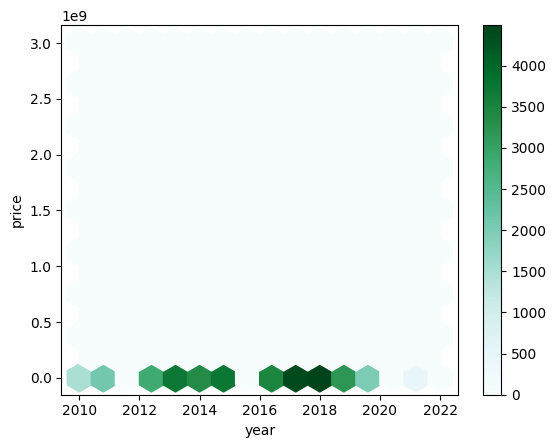

In [14]:
vehicle_df_2010_ca.plot.hexbin(x='year', y='price', gridsize=15)

In [15]:
#remove price outliers

# Calculate the z-score for each student's height
z = np.abs(stats.zscore(vehicle_df_2010_ca['price']))

# Identify outliers as students with a z-score greater than 3
threshold = 2
outliers = vehicle_df_2010_ca[z > threshold]

# Print the outliers
print(outliers)



        region       price  year manufacturer model condition    cylinders  \
37409  modesto  1111111111  2020         jeep   NaN       NaN          NaN   
37410  modesto  3009548743  2021    chevrolet   NaN       NaN  8 cylinders   

      fuel  odometer title_status transmission drive size type paint_color  \
37409  gas    1000.0        clean    automatic   4wd  NaN  NaN         NaN   
37410  gas    1000.0        clean    automatic   4wd  NaN  NaN         NaN   

      state odometer_interval  
37409    ca             0-50k  
37410    ca             0-50k  


In [16]:
all_outliers = vehicle_df_2010_ca.query('price > 300000')

In [17]:
vehicle_df_2010_ca = vehicle_df_2010_ca.drop(all_outliers.index)

                                             |          | [  0%]   00:00 -> (? left)


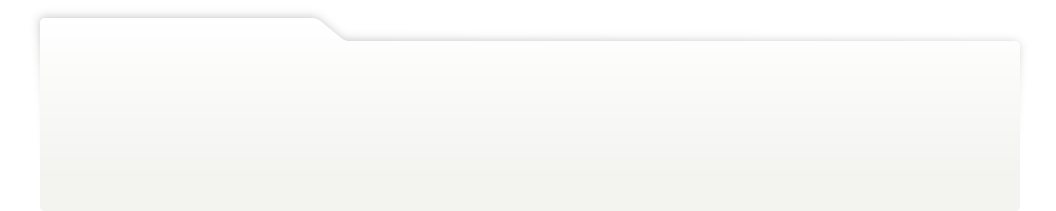
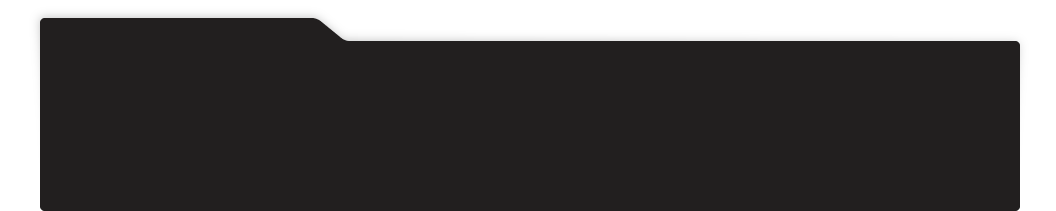
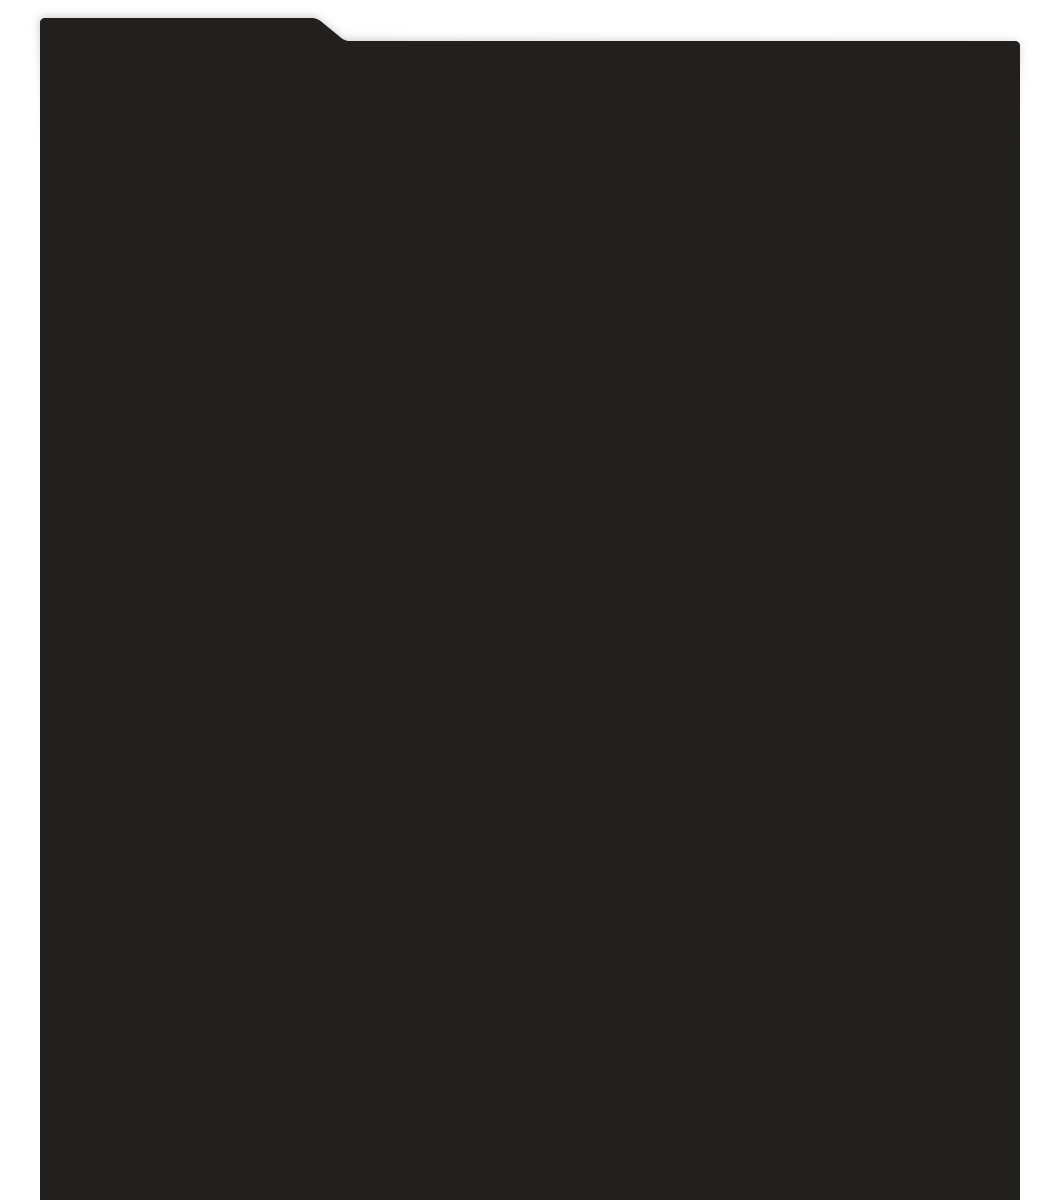
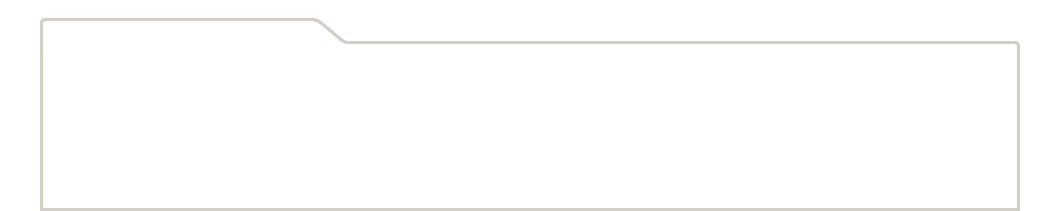
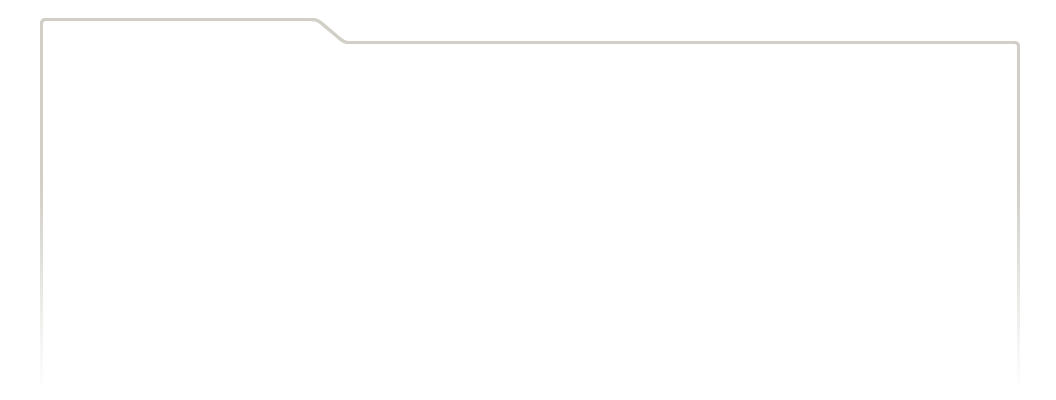
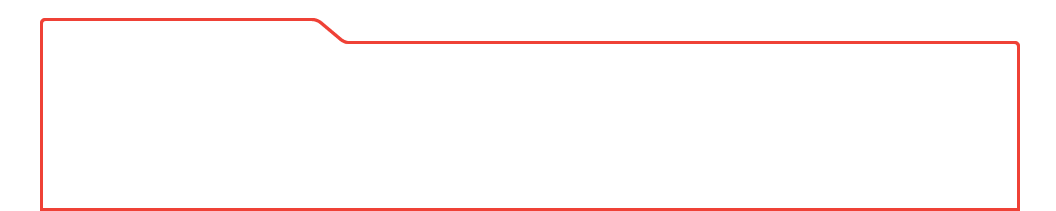
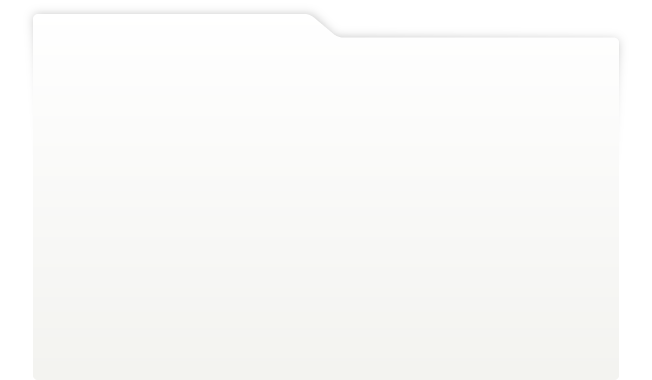
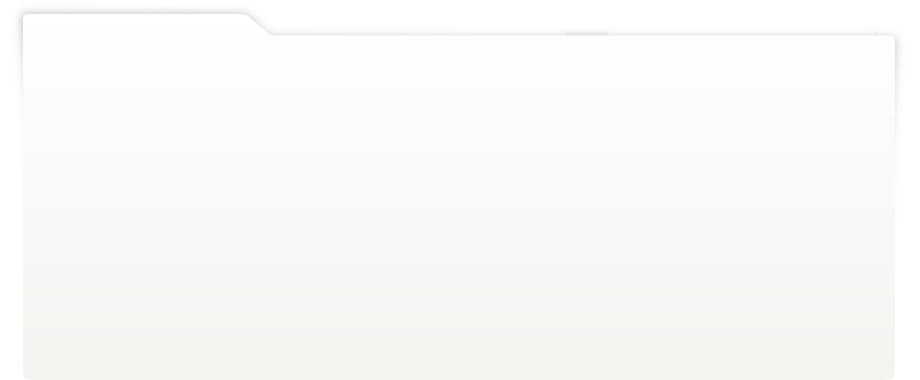
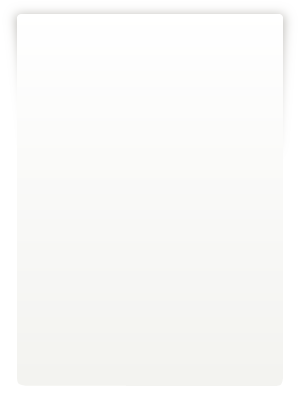
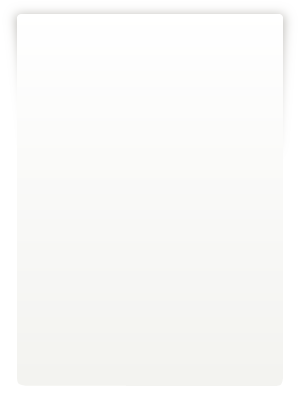
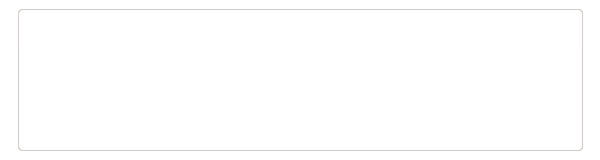
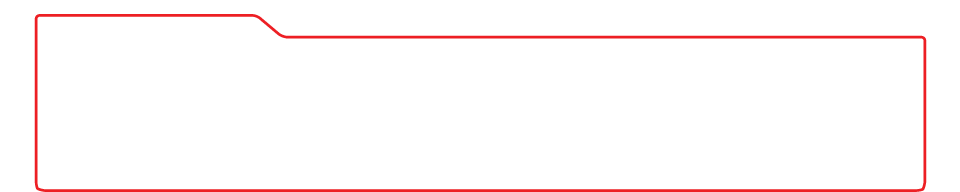
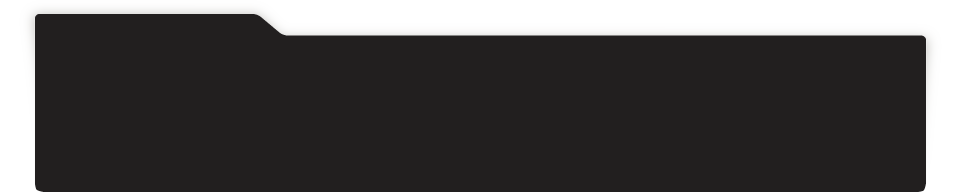
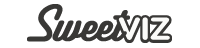
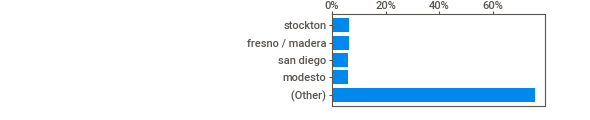
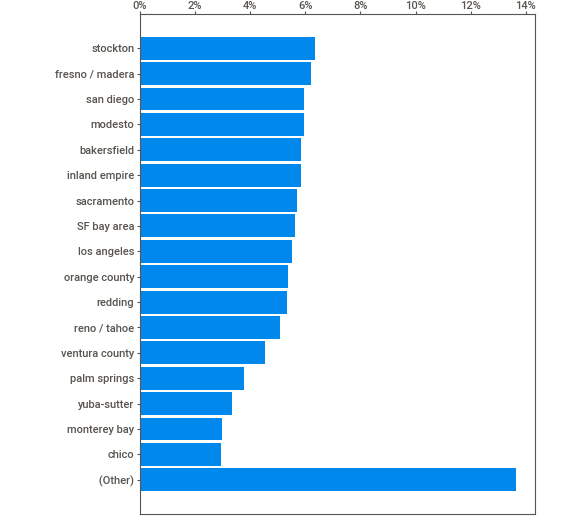
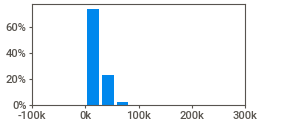
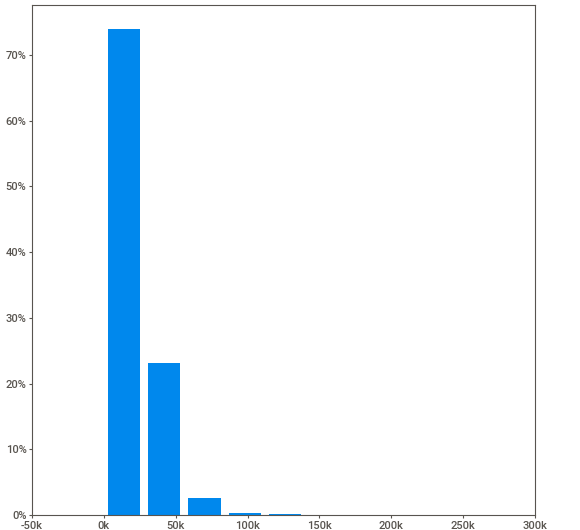
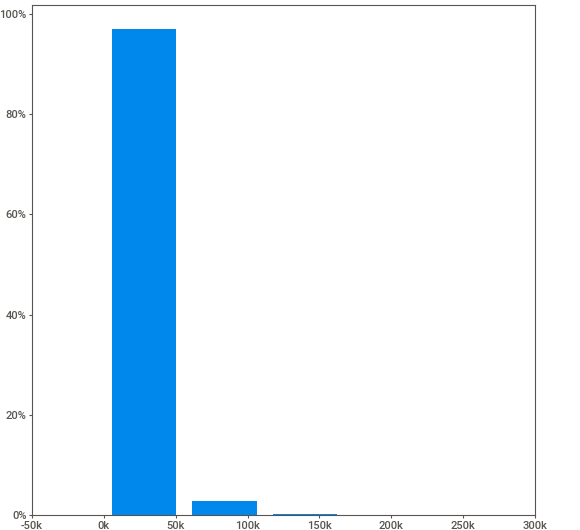
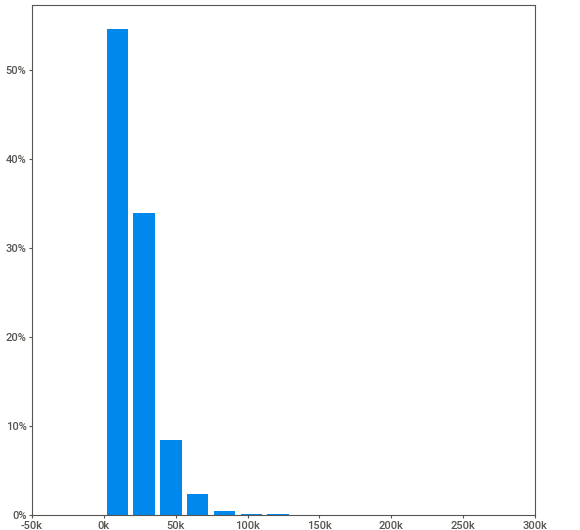
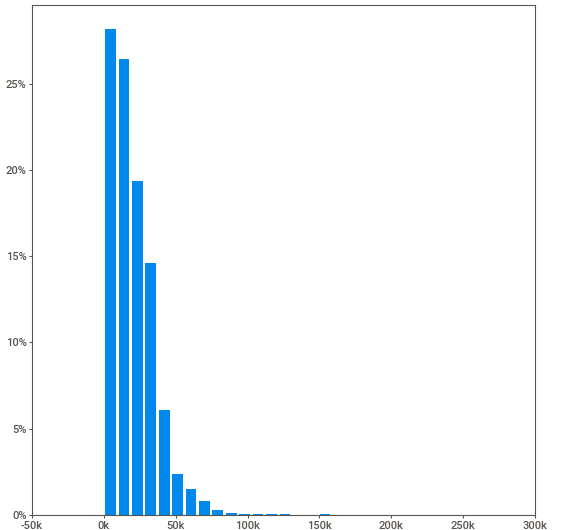
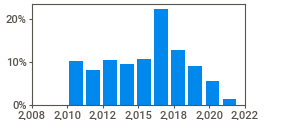
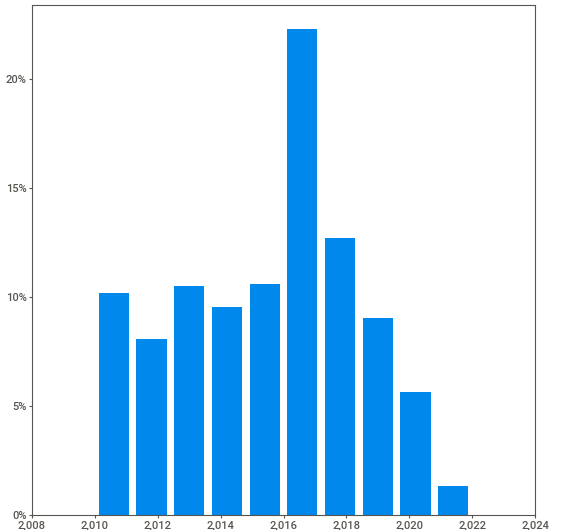
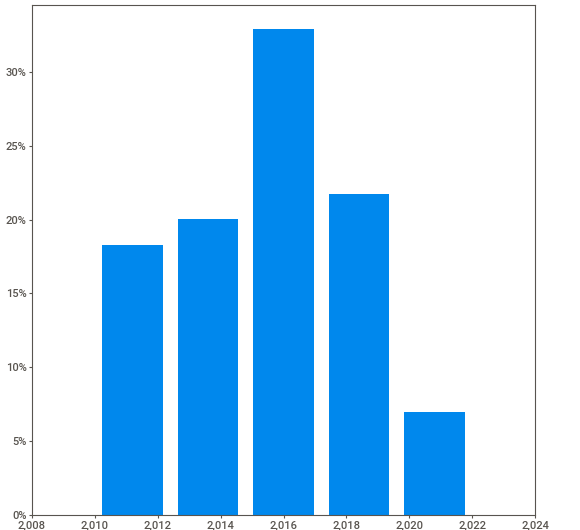
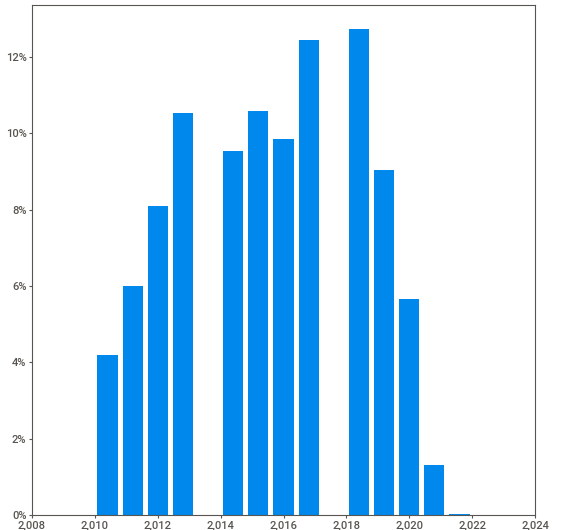
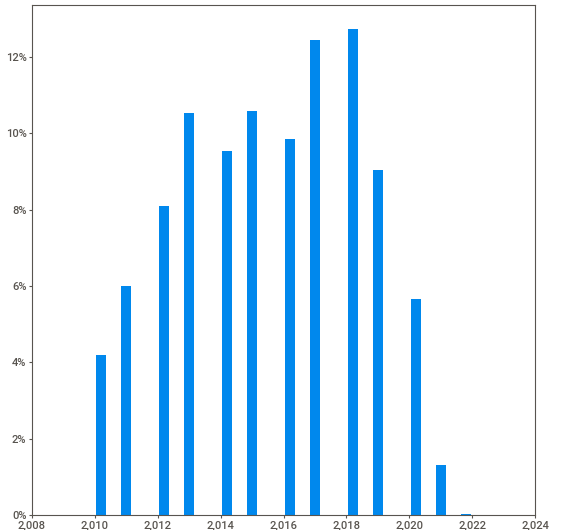
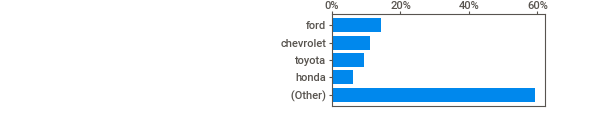
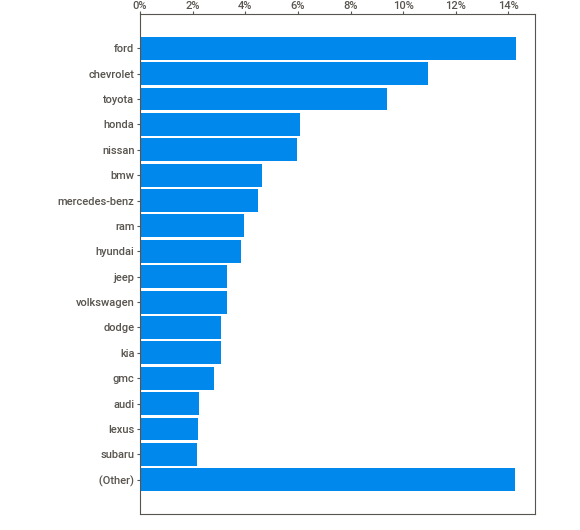
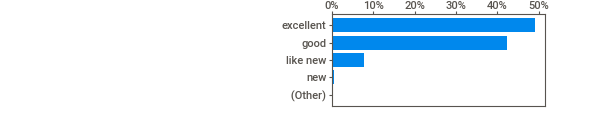
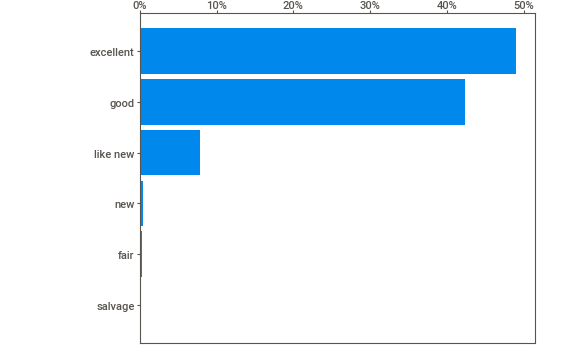
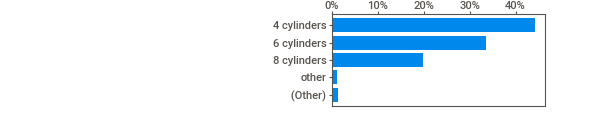
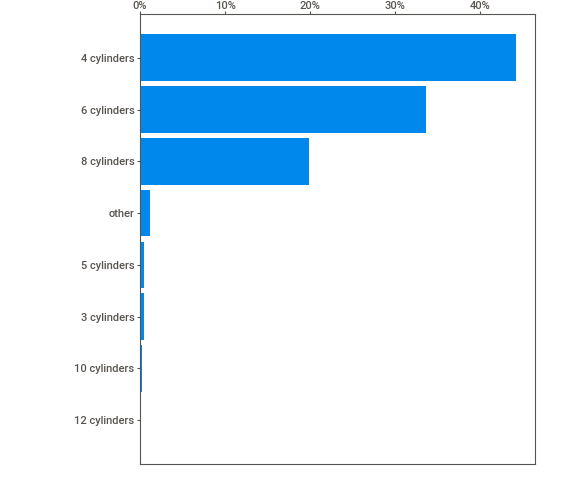
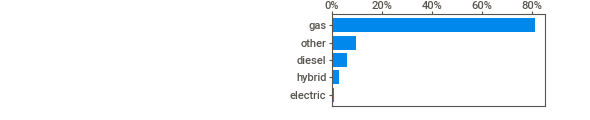
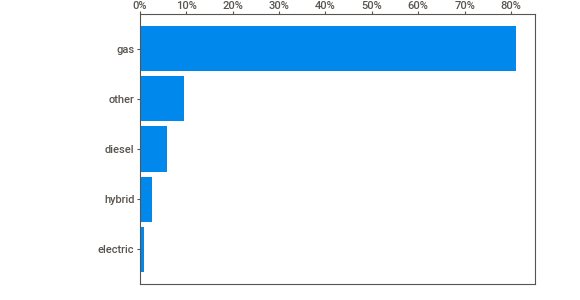
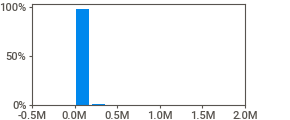
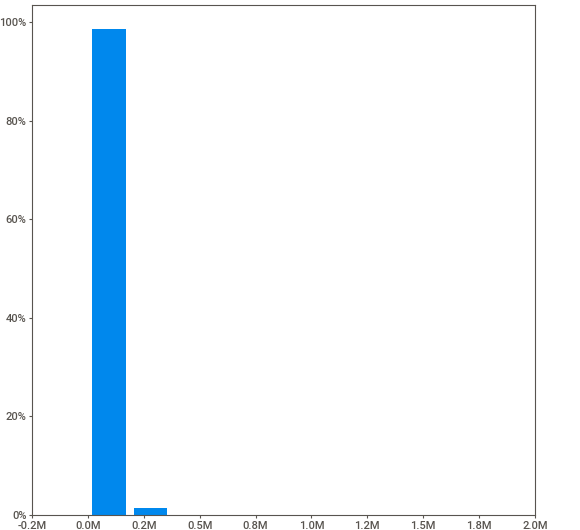
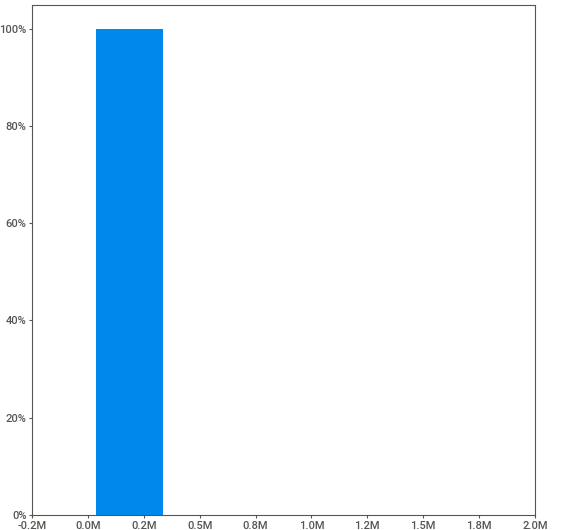
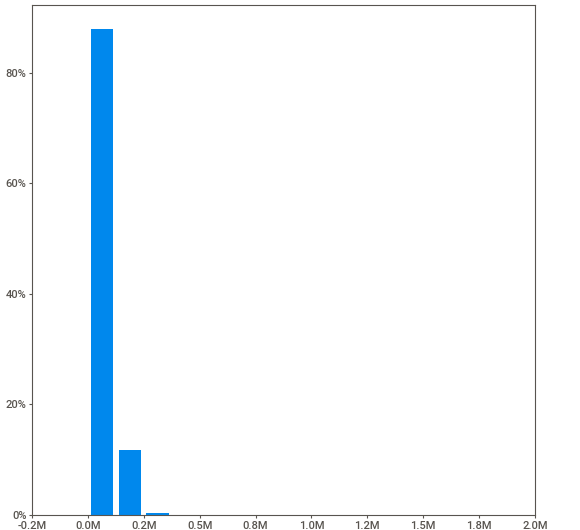
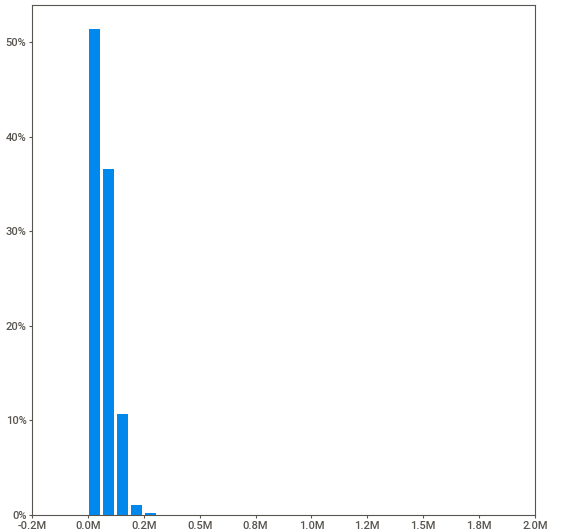
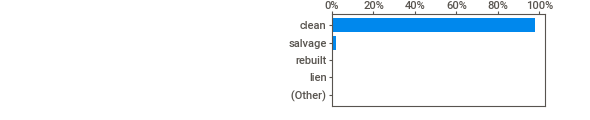
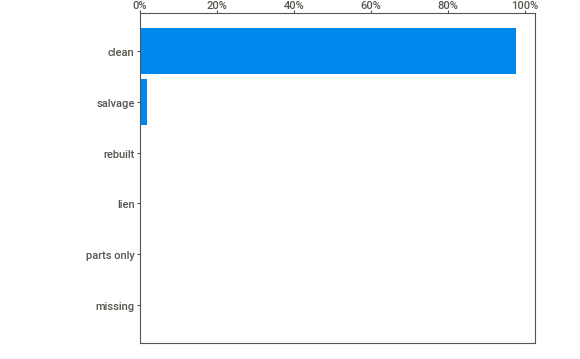
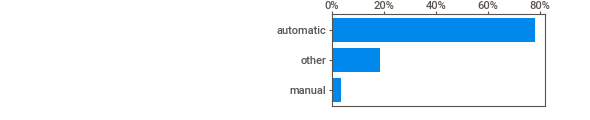
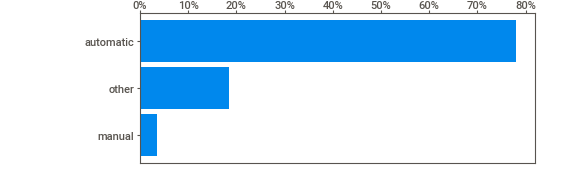
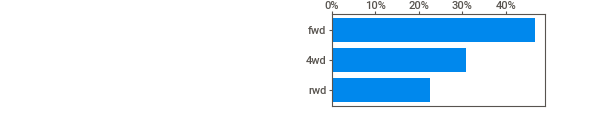
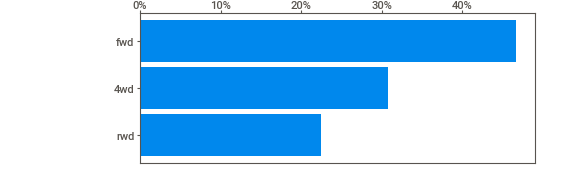
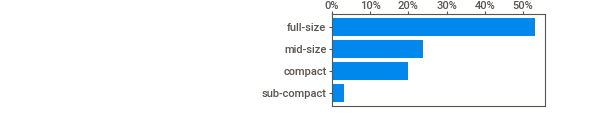
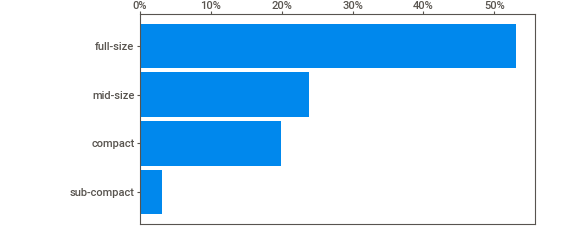
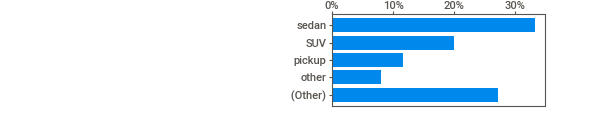
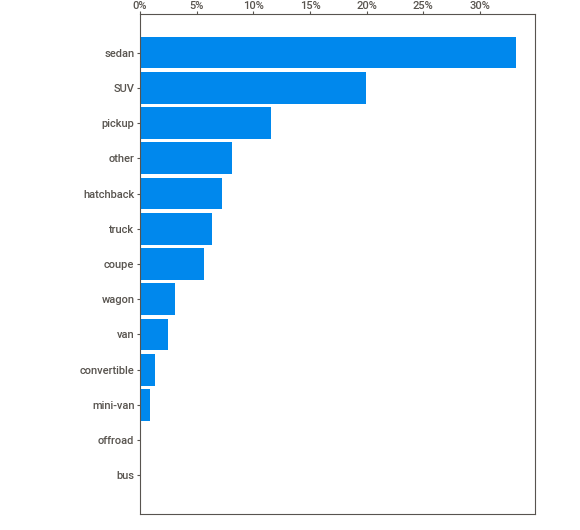
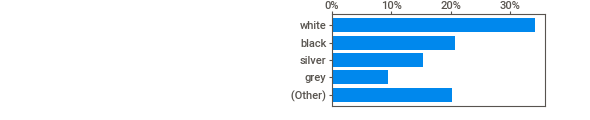
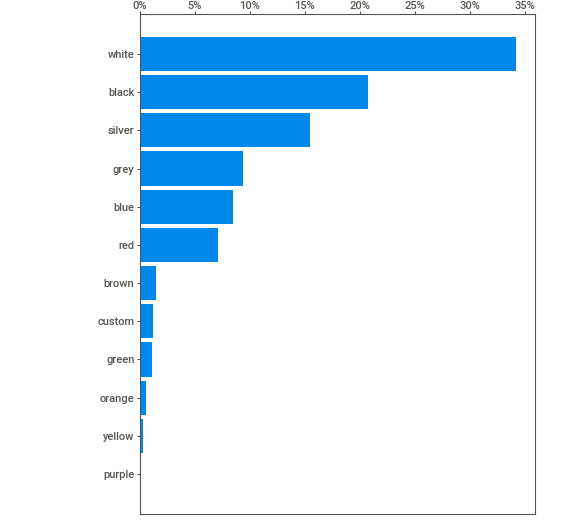
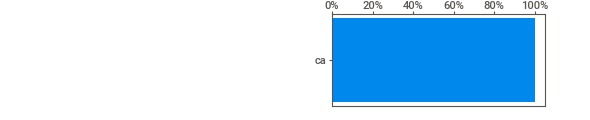
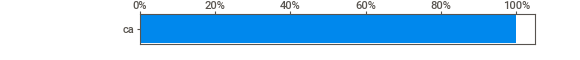
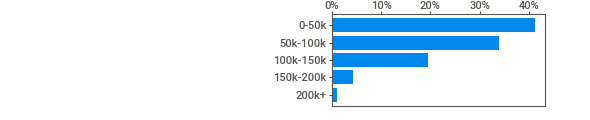
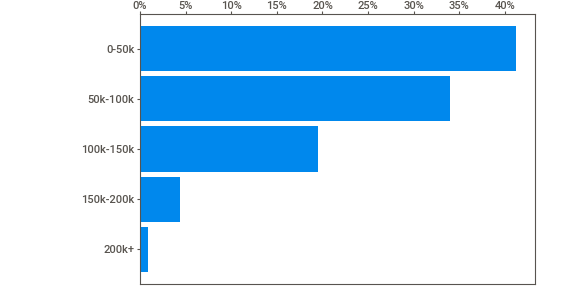
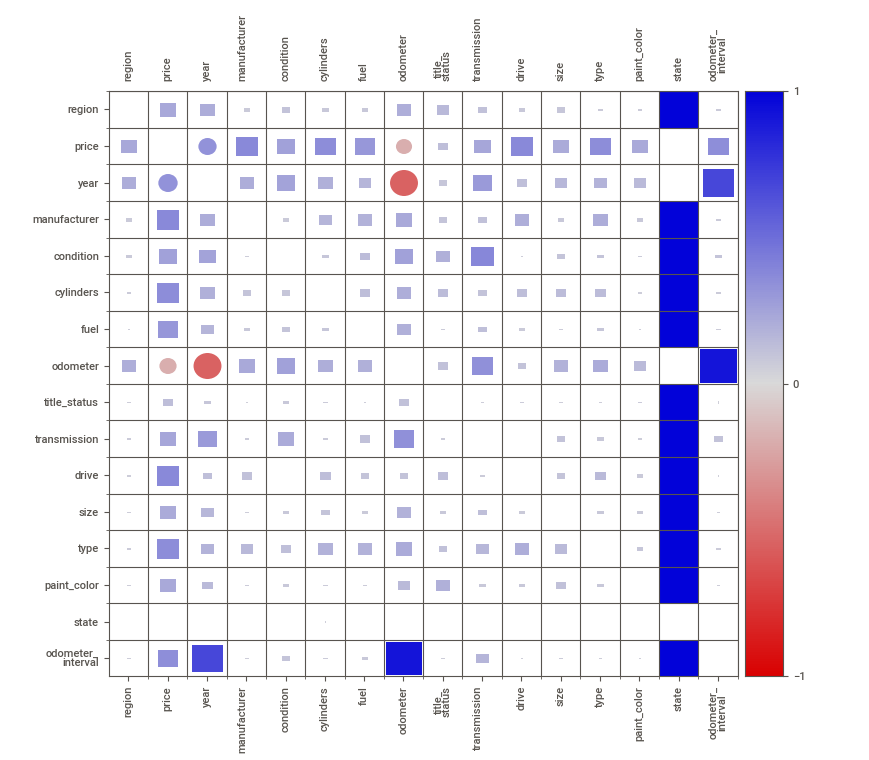
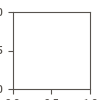

In [18]:
analyze_report = sv.analyze(vehicle_df_2010_ca)
analyze_report.show_notebook(w=1500, h=500, scale=0.8)

In [19]:
analyze_report.show_html(filepath=f'{image_dir}/data_analysis.html')

Report /content/drive/MyDrive/Colab Notebooks/practical_application_II_starter 2/images/data_analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Based on the initial analysis the columns with the most missing values are:

*   size 77%
*   cylinders 45%
*   condition 37%
*   drive 30%
*   paint_color 32%





In [20]:
def analysis_plots(df, column_name, image_dir, filename):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  sns.countplot(x=column_name, hue=column_name, data = df, palette = 'pastel',
                legend = False,
                order = df[column_name].value_counts().index, ax = axes[0]
                ,)

  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
  axes[0].set_title(f'Distribution by {column_name} of Vehicles')
  axes[0].set_xlabel(f'Vehicles {column_name}')
  axes[0].set_ylabel('Counts in dataset')



  car_plot = df.groupby(column_name)['price'].mean().sort_values(ascending=False)
  sns.barplot(x = car_plot.index, y = car_plot.values, palette = 'pastel', hue=car_plot.index, legend=False, ax=axes[1])
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
  axes[1].set_title(f'Average Price of Vehicles by {column_name}')
  axes[1].set_xlabel(f'Vehicles {column_name}')
  axes[1].set_ylabel('Average Price')

  plt.savefig(f'{image_dir}/{column_name}_{filename}.jpg', bbox_inches='tight')
  fig.tight_layout()
  plt.show()

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



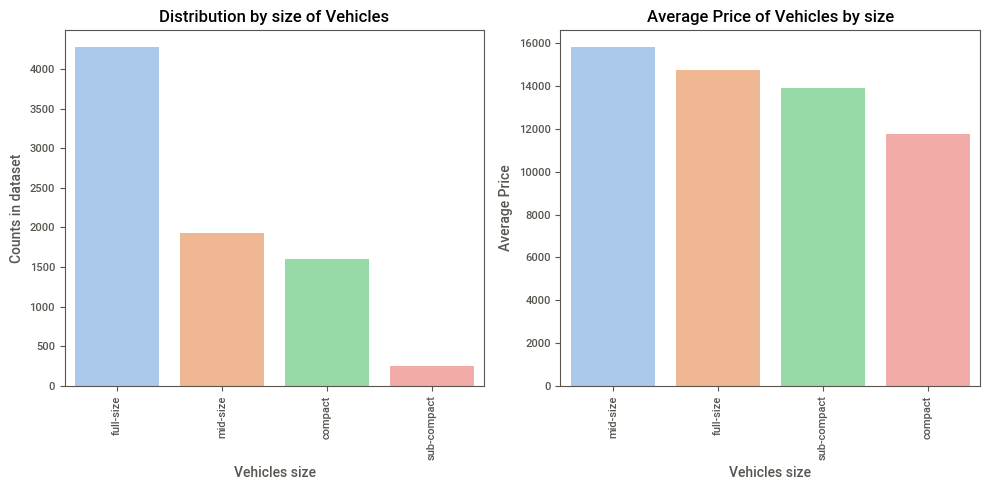

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



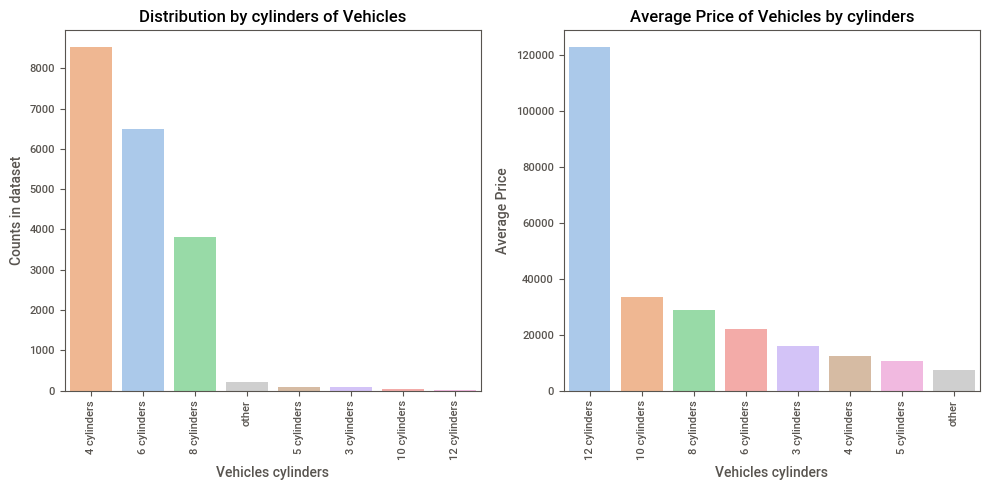

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



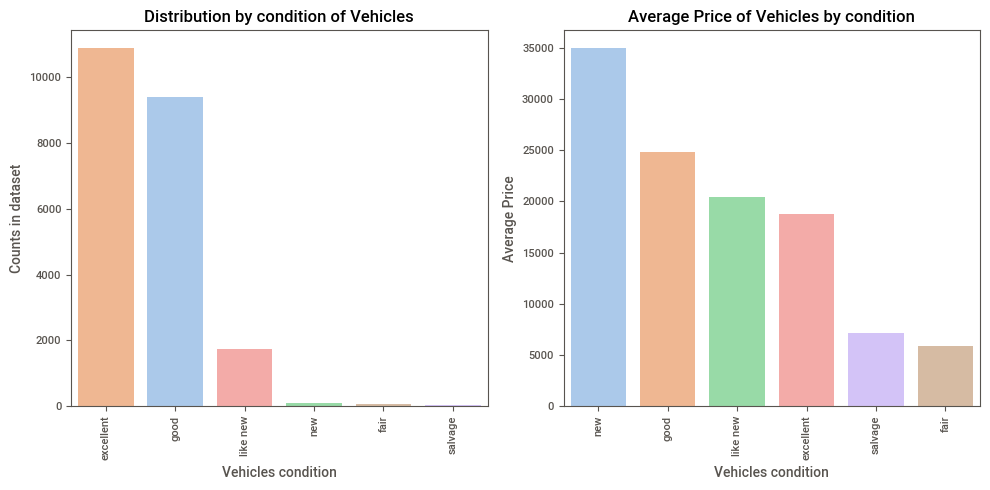

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



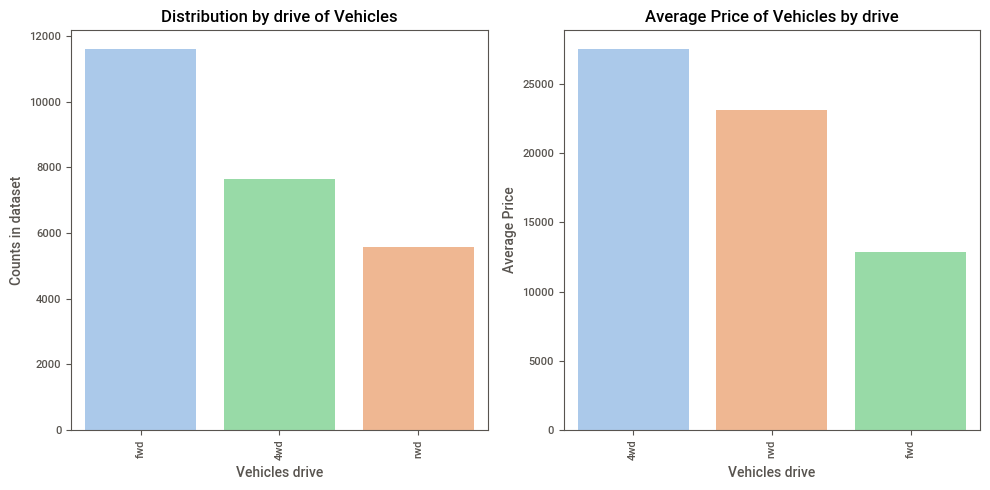

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



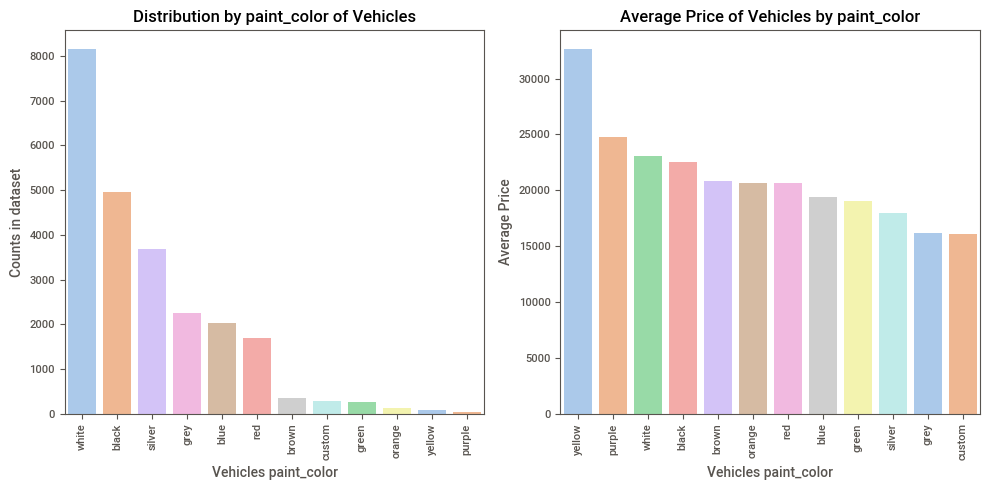

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



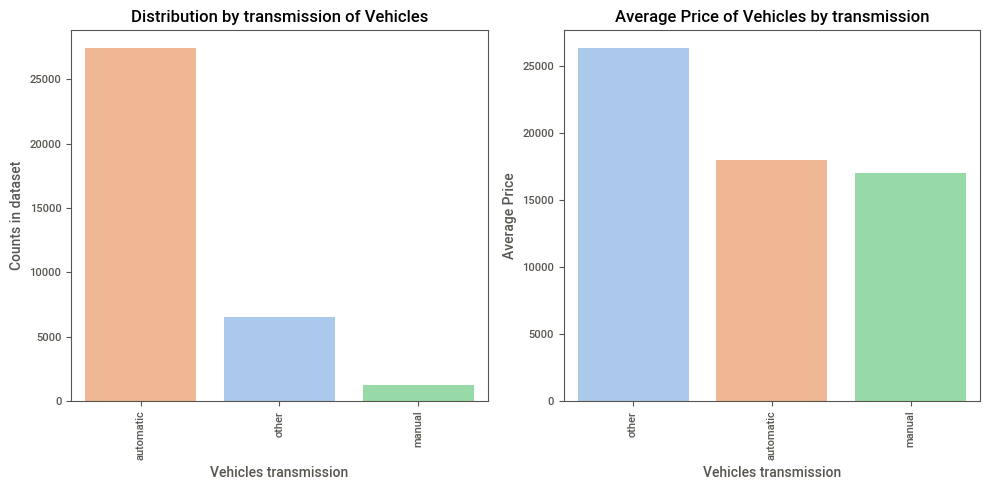

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



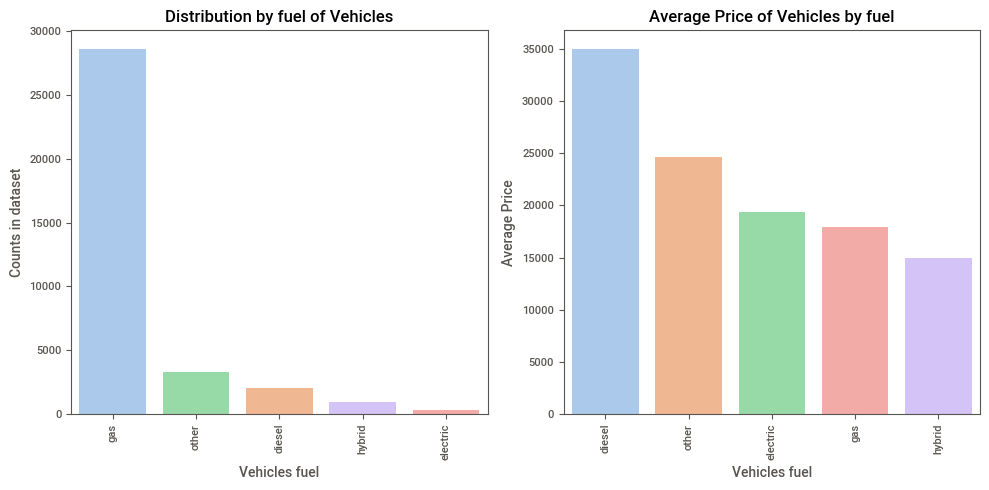

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



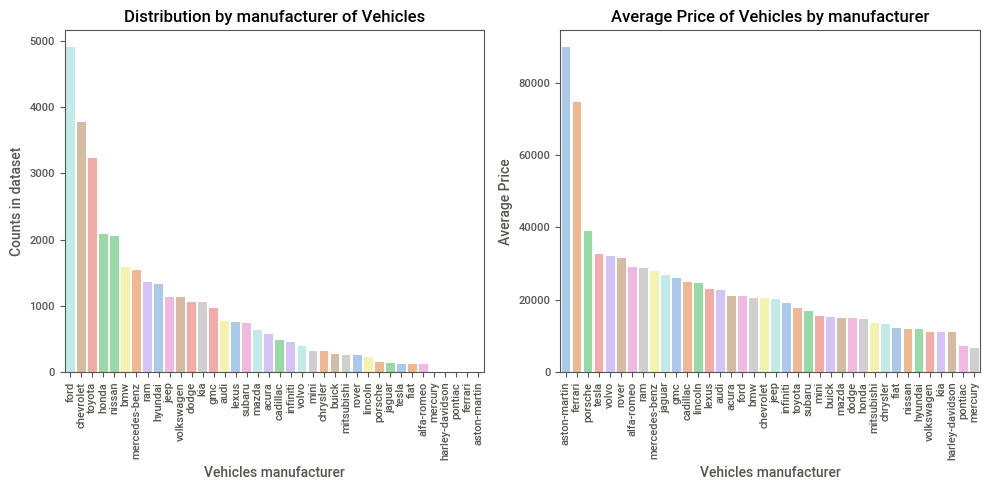

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



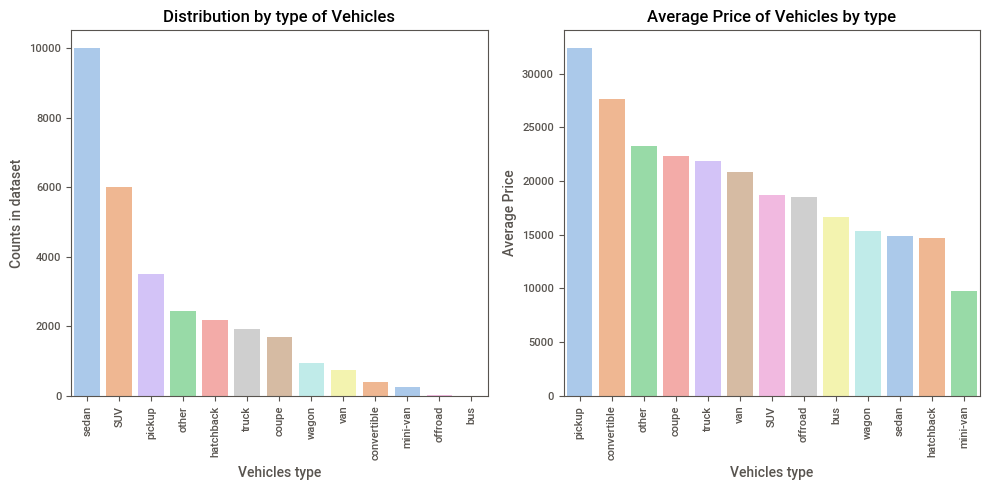

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



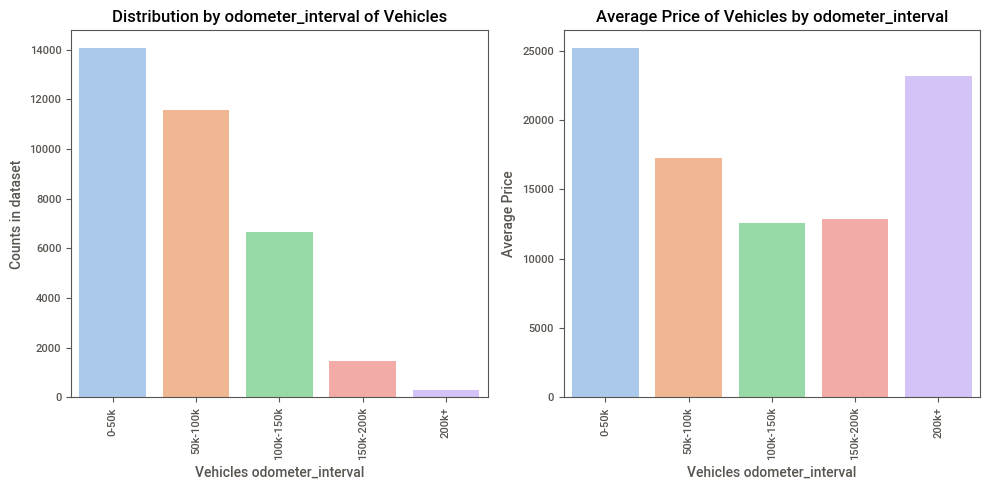

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



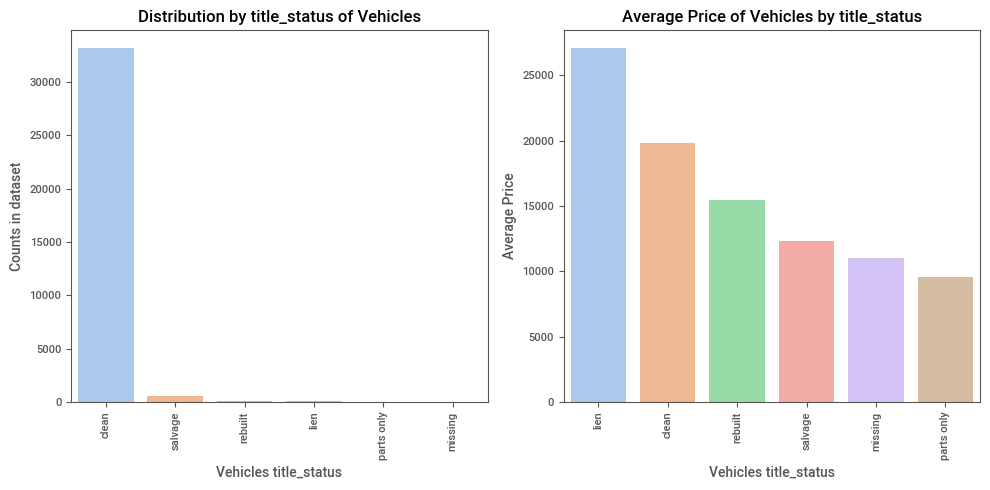

In [21]:
for column in ['size', 'cylinders', 'condition', 'drive', 'paint_color',
               'transmission', 'fuel', 'manufacturer', 'type', 'odometer_interval', 'title_status']:
  analysis_plots(vehicle_df_2010_ca, column, image_dir, 'california')

**Analysis by Size of the vehicle**

The dataset is dominated by full-size cars. However, the average price of vehicles is highest for mid-size cars, followed by full-size cars.

**Distribution by Transmission Type**

As expected, Automatic cars are the most popular and are priced higher.

**Distribution by Fuel Type**

Gas cars are the most popular, but diesel cars have a higher average price.

***By Manufacturer***

Ford is the most popular manufacturer in the dataset followed by Chevrolet and Toyota. Significantly few people buy a Ferrari or an Aston Martin, so if you want a good volume of sales, then it won't be worth selling those cars to average folks.

The following manufacturers have the most expensive cars in descending order:
*   Ferrari
*   Aston Martin






**Analysis by Odometer**

As expected, cars that have smaller odometer readings sell for more money.

**Analysis by Condition**

Most of the vehicles are in excellent condition; the price of the cars is highest when they are in new, good, or like-new condition.

**Analysis by Type**

 Sedans and SUVs are the most popular types of vehicles. However, they are the medium expensive varieties. The most expensive vehicles are the pickups and convertibles

**Analysis by paint_color**

White is the most commonly selling color, while yellow cars sell for more money.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

Clean Model

Ferraris and Aston Martins are the most expensive cars in California. There are only 8 represented in the dataset. Removing them to focus on the less niche cars.

In [23]:
vehicle_df_2010_ca.query('manufacturer == "ferrari" or manufacturer == "aston-martin"')[['region', 'manufacturer']].value_counts()

,,count
region,manufacturer,
orange county,ferrari,3
monterey bay,ferrari,1
orange county,aston-martin,1
stockton,aston-martin,1


In [24]:
vehicle_df_2010_ca.query('manufacturer == "ferrari" or manufacturer == "aston-martin"')

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,odometer_interval
40072,monterey bay,0,2010,ferrari,NaN,NaN,4 cylinders,hybrid,42101.0,clean,automatic,4wd,compact,convertible,black,ca,0-50k
42315,orange county,0,2016,ferrari,california,NaN,8 cylinders,gas,11893.0,clean,automatic,rwd,NaN,convertible,grey,ca,0-50k
43380,orange county,153880,2017,ferrari,california t,like new,8 cylinders,gas,18364.0,clean,automatic,NaN,NaN,convertible,black,ca,0-50k
43630,orange county,179888,2018,aston-martin,martin db11,like new,12 cylinders,gas,7800.0,clean,automatic,NaN,NaN,NaN,white,ca,0-50k
43918,orange county,144888,2013,ferrari,ff,excellent,8 cylinders,gas,25000.0,clean,automatic,NaN,NaN,NaN,black,ca,0-50k
66243,stockton,0,2014,aston-martin,martin vanquish v12,good,NaN,other,34445.0,clean,automatic,rwd,NaN,coupe,silver,ca,0-50k


In [25]:
vehicle_df_2010_ca.drop(vehicle_df_2010_ca.query('manufacturer == "ferrari" or manufacturer == "aston-martin"').index, inplace=True)

In [26]:
# Clean the model names
vehicle_df_2010_ca['model_clean'] = vehicle_df_2010_ca['model'].str.lower().str.strip().str.split().str[0]


#droping the model column and replacing it with the new cleaned column
vehicle_df_2010_ca.drop(columns=["model", "state","odometer_interval"], axis = 1, inplace=True)
vehicle_df_2010_ca.rename(columns={"model_clean": "model"},inplace=True)

In [27]:
#creating a column "age"
vehicle_df_2010_ca['present year'] = 2022.5
vehicle_df_2010_ca['age'] = vehicle_df_2010_ca['present year'] - vehicle_df_2010_ca['year']
vehicle_df_2010_ca.drop(['present year'], inplace = True, axis = 1)

In [28]:
vehicle_df_2010_ca.groupby('condition')[['age','price','odometer']].mean().sort_values(by=['age'], ascending=True)

,age,price,odometer
condition,,,
new,4.200000,34967.240000,37794.570000
good,6.260791,24812.467149,49402.206677
like new,7.130145,20246.982609,67567.143188
excellent,7.788260,18711.328403,77338.902444
salvage,8.685185,7155.407407,94271.333333
fair,9.520000,5888.980000,145023.620000


**Null Handling**

In [29]:
for cols in vehicle_df_2010_ca.columns:
  if vehicle_df_2010_ca[cols].dtype == 'object':
      vehicle_df_2010_ca[cols] = vehicle_df_2010_ca[cols].fillna('Unknown')
  elif vehicle_df_2010_ca[cols].dtype == 'numeric':
      vehicle_df_2010_ca[cols] = vehicle_df_2010_ca[cols].fillna(-1)
      # Add 'Unknown' to the categories and then fill NaNs
  else:
      vehicle_df_2010_ca[cols] = vehicle_df_2010_ca[cols].fillna("Unknown")
  #print(f"{cols}: {vehicle_df_2010[cols].isnull().sum()}") # Verify no more missing values

**Encode the data**

In [30]:
numerical_features = ["year","odometer","age"]
categorical_features = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel','title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'model']

n_unique_categories = vehicle_df_2010_ca[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories
high_cardinality_features = n_unique_categories[n_unique_categories > 30].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 30].index

print(high_cardinality_features)
print(low_cardinality_features)

Index(['model', 'manufacturer'], dtype='object')
Index(['region', 'type', 'paint_color', 'cylinders', 'condition',
       'title_status', 'fuel', 'size', 'drive', 'transmission'],
      dtype='object')


In [31]:
vehicle_df_2010_ca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35294 entries, 21171 to 71784
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        35294 non-null  object 
 1   price         35294 non-null  int64  
 2   year          35294 non-null  int64  
 3   manufacturer  35294 non-null  object 
 4   condition     35294 non-null  object 
 5   cylinders     35294 non-null  object 
 6   fuel          35294 non-null  object 
 7   odometer      35294 non-null  float64
 8   title_status  35294 non-null  object 
 9   transmission  35294 non-null  object 
 10  drive         35294 non-null  object 
 11  size          35294 non-null  object 
 12  type          35294 non-null  object 
 13  paint_color   35294 non-null  object 
 14  model         35294 non-null  object 
 15  age           35294 non-null  float64
dtypes: float64(2), int64(2), object(12)
memory usage: 4.6+ MB


**Transform the data**

In [32]:

categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_transformer_target = Pipeline(steps=[("target", TargetEncoder(target_type="continuous"))])
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

In [33]:
pipe = Pipeline(
    steps=[
        (
            "columntransformer",
            ColumnTransformer(
                transformers=[
                    # Add a name for the categorical transformer
                    ("catonehot", categorical_transformer_onehot, low_cardinality_features),
                    ("cattgt", categorical_transformer_target, high_cardinality_features),
                    # Add a name for the numerical transformer
                    ("num", numerical_transformer, numerical_features),
                ]
            ),
        ),
        ("scaled", MinMaxScaler())
    ])


In [34]:
from sklearn import set_config
set_config(transform_output="pandas")

X = vehicle_df_2010_ca.drop(['price'], axis=1)
y = vehicle_df_2010_ca['price']

X_prep = pipe.fit_transform(X,y)

In [106]:
feature_names = pipe.named_steps['columntransformer'].get_feature_names_out()

In [107]:
feature_names

array(['catonehot__region_los angeles', 'catonehot__type_SUV',
       'catonehot__type_Unknown', 'catonehot__type_convertible',
       'catonehot__type_coupe', 'catonehot__type_hatchback',
       'catonehot__type_mini-van', 'catonehot__type_offroad',
       'catonehot__type_other', 'catonehot__type_pickup',
       'catonehot__type_sedan', 'catonehot__type_truck',
       'catonehot__type_van', 'catonehot__type_wagon',
       'catonehot__paint_color_Unknown', 'catonehot__paint_color_black',
       'catonehot__paint_color_blue', 'catonehot__paint_color_brown',
       'catonehot__paint_color_custom', 'catonehot__paint_color_green',
       'catonehot__paint_color_grey', 'catonehot__paint_color_orange',
       'catonehot__paint_color_red', 'catonehot__paint_color_silver',
       'catonehot__paint_color_white', 'catonehot__paint_color_yellow',
       'catonehot__cylinders_10 cylinders',
       'catonehot__cylinders_3 cylinders',
       'catonehot__cylinders_4 cylinders',
       'catonehot__cy

**Split test and train set**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size = 0.3, random_state = 42)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [112]:


model_grids = pd.DataFrame([], columns=['model', 'pipe','grid_search_parameters'])
error_function = 'neg_mean_absolute_error'

def append_results(model_name, train_preds, test_preds, grid, final_results, y_test, y_train):
  model_train_mae = mean_absolute_error(y_train, train_preds)
  model_test_mae = mean_absolute_error(y_test, test_preds)
  model_best_estimator = grid.best_estimator_
  model_best_params = grid.best_params_
  model_mean_fit_time = np.mean(grid.cv_results_["mean_fit_time"])
  results_column_list = final_results.columns
  # Pass the data as a list of lists to create a single row with 5 columns
  results = pd.DataFrame([[model_name, model_best_estimator, model_train_mae, model_test_mae, model_best_params, model_mean_fit_time]], columns=results_column_list)
  return pd.concat([final_results, results])


# Create a scatter plot of actual vs predicted values
def plot_results(model, test_preds, y_test, filename):
  plt.figure(figsize = (5, 5))
  sns.regplot(y = test_preds, x = y_test, color = 'steelblue', marker = 'o')
  plt.title(f"Comparision of predicted values and the actual values for {model}", fontsize = 20)
  plt.xlabel("Actual Values", fontsize = 15)
  plt.ylabel("Predicted Values", fontsize = 15)
  plt.savefig(f'{image_dir}/{model}_{filename}.png')
  plt.show()


#Plot Coefficients for Feature Importance
def coefficients(model_best_estimator, model):

  if model == 'Ridge Regressor':
    estimator = model_best_estimator.named_steps['ridge']
  elif model == 'KNN Regressor':
    estimator = model_best_estimator.named_steps['knn']
  elif model == 'Gradient Boosting Regressor':
    estimator = model_best_estimator.named_steps['grad']
  elif model == 'Decision Tree Regressor':
    estimator = model_best_estimator.named_steps['dt']
  elif model == 'MLPRegressor':
    estimator = model_best_estimator.named_steps['mlp']
  else:
    print("Model not supported")

  # Crteate a Panda series and print or use coefficients:
  coef_series = pd.Series(estimator.coef_, index=feature_names).sort_values(ascending=False)

  plt.figure(figsize = (15, 5))
  coef_series.plot(kind = 'bar', color = 'g')
  plt.title("Scaled Ridge Model Coefficient", fontsize = 10)
  plt.show()



def evaluate_models(model_grids, scoring, X_train, X_test, y_train, y_test, filename=""):
  results_column_list = ['Model', 'Best Estimator', 'Train MAE', 'Test MAE', 'Best Parameters', 'Mean Fit Time']
  final_results = pd.DataFrame([], columns=results_column_list)
  # Assuming model_grids is a DataFrame
  for _, row in model_grids.iterrows():
      model, pipe, grid_search_param = row
      grid = GridSearchCV(pipe, grid_search_param, cv=5, verbose=0, n_jobs=-1, scoring=scoring, refit=True)
      grid.fit(X_train, y_train)
      train_preds = grid.predict(X_train)
      test_preds = grid.predict(X_test)

      final_results = append_results(model, train_preds, test_preds, grid, final_results, y_test, y_train)
      plot_results(model, test_preds, y_test, filename)

  return final_results

**Ridge Regression**

In [37]:
#creating a Pipeline to scale and apply Ridge regressor.
model = 'Ridge Regressor'
pipe_ridge = Pipeline(
    steps=[
        ('ridge', Ridge())
    ]
)

param_dict_ridge = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

model_grids.loc[len(model_grids)] = [model, pipe_ridge, param_dict_ridge]

**KNN**

In [38]:
model = 'KNN Regressor'
pipe_knn = Pipeline(
    steps=[
        ('knn', KNeighborsRegressor(n_neighbors = 2))
    ]
)

param_dict_knn = {'knn__n_neighbors': [1, 5, 10]}


model_grids.loc[len(model_grids)] = [model, pipe_knn, param_dict_knn]



**Gradient Boosting Regressor**

In [39]:
model = 'Gradient Boosting Regressor'
pipe_grad = Pipeline(
    steps=[
        ('grad', GradientBoostingRegressor(loss='huber'))
    ]
)

param_dict_grad =  {'grad__n_estimators': [100, 200],
               'grad__learning_rate': [0.01, 0.0],
               'grad__max_depth': [3, 5]}

model_grids.loc[len(model_grids)] = [model, pipe_grad, param_dict_grad]

**Decision Tree Regressor**

In [40]:
model = 'Decision Tree Regressor'

dt_pipe = Pipeline(
    steps=[
        ('dt', DecisionTreeRegressor())
    ]
)

param_dict =  {'dt__min_samples_leaf': [1, 5],
               'dt__max_depth': [3, 5]}

model_grids.loc[len(model_grids)] = [model, dt_pipe, param_dict]

**MLP Regressor**

In [41]:
model = 'MLPRegressor'

mlp_pipe = Pipeline(
    steps=[
        ('mlp', MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive'))
    ]
)

param_dict_mlp = {"mlp__hidden_layer_sizes": [(1,), (50,)],}

model_grids.loc[len(model_grids)] = [model, mlp_pipe, param_dict_mlp]

**Evaluate All Regression Models**

<ipython-input-36-ec9c1cd202f3>:13: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



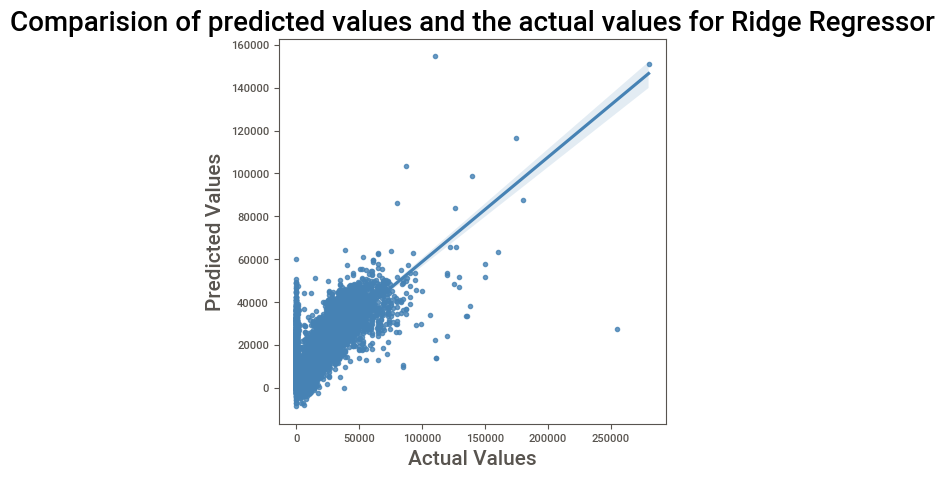

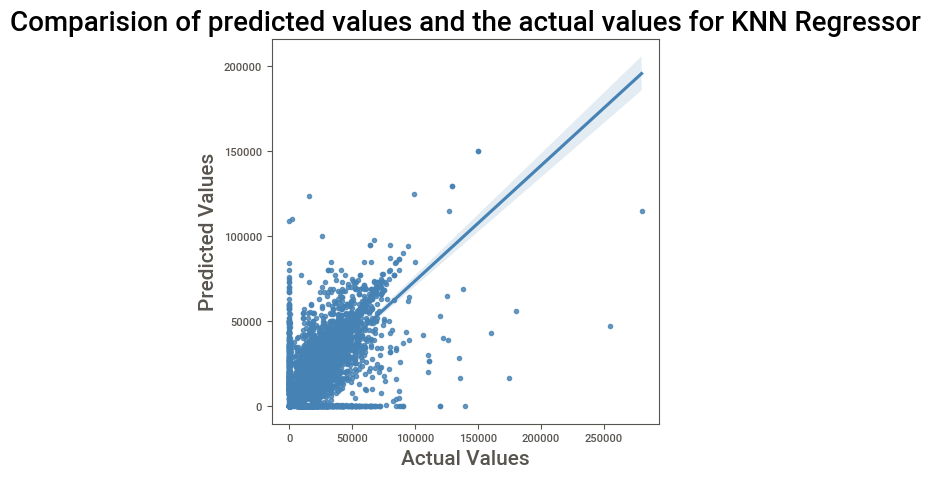

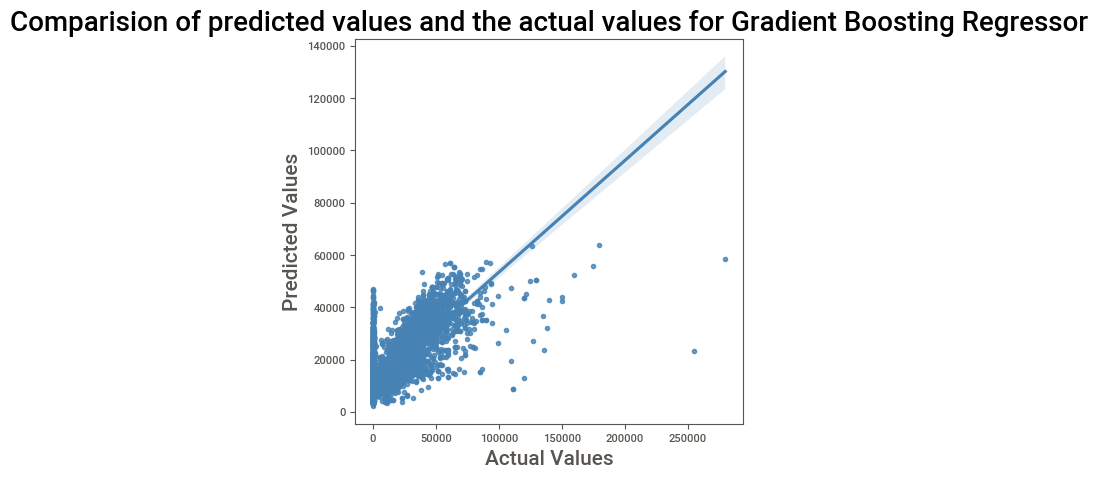

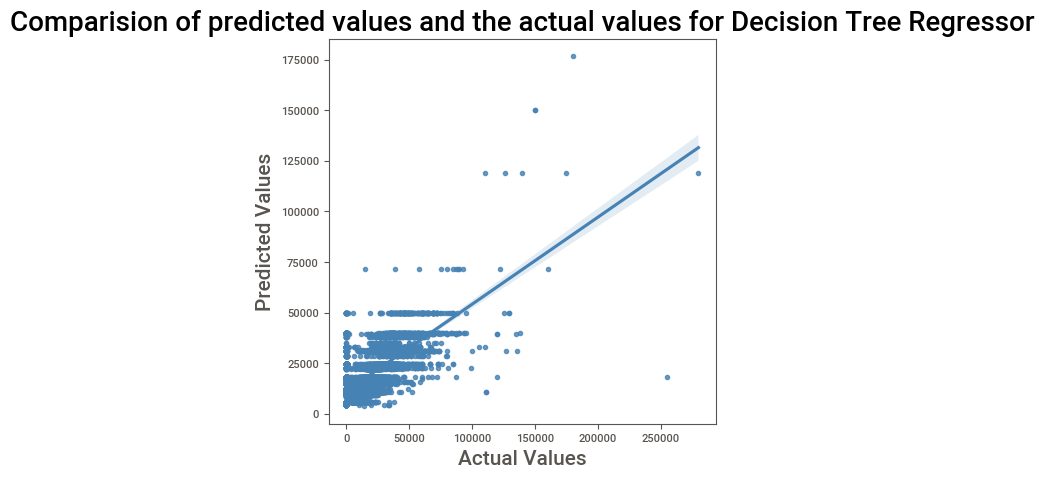

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



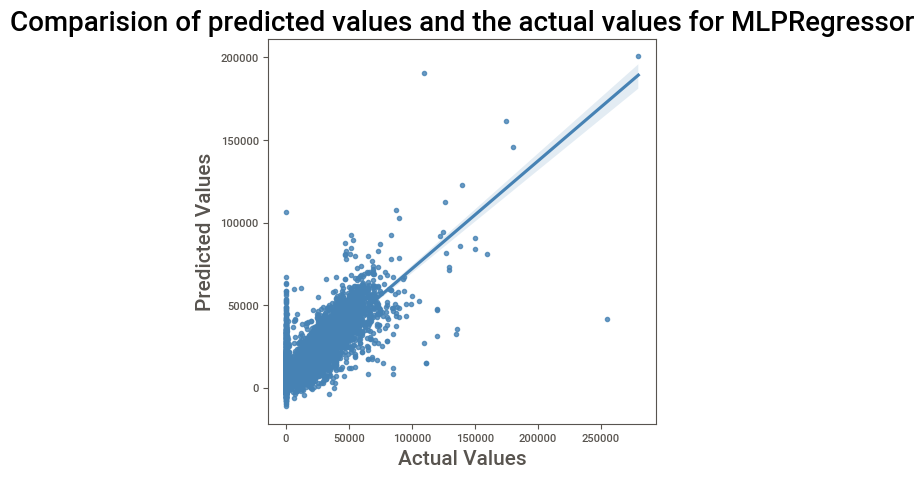

In [42]:
final_results = evaluate_models(model_grids, scoring = 'neg_mean_absolute_error', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [43]:
print(final_results)

                         Model  \
0              Ridge Regressor   
0                KNN Regressor   
0  Gradient Boosting Regressor   
0      Decision Tree Regressor   
0                 MLPRegressor   

                                      Best Estimator    Train MAE  \
0                                          (Ridge())  7617.630917   
0               (KNeighborsRegressor(n_neighbors=1))    10.406517   
0  (([DecisionTreeRegressor(criterion='friedman_m...  6776.910114   
0               (DecisionTreeRegressor(max_depth=5))  8127.649436   
0  (MLPRegressor(alpha=0.001, hidden_layer_sizes=...  5646.435250   

      Test MAE                                    Best Parameters  \
0  7622.989561                              {'ridge__alpha': 1.0}   
0  5388.804042                            {'knn__n_neighbors': 1}   
0  6893.429408  {'grad__learning_rate': 0.01, 'grad__max_depth...   
0  8195.309958    {'dt__max_depth': 5, 'dt__min_samples_leaf': 1}   
0  6049.358704                 {'ml

In [44]:
import pickle
# Save the DataFrame to a pickle file
pkl_path = f'{data_dir}/final_results.pkl'

final_results.to_pickle(pkl_path)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

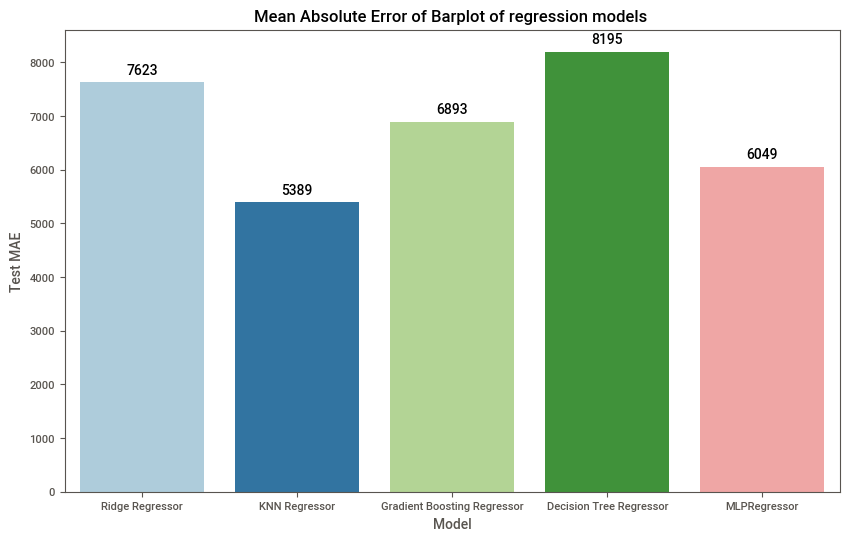

In [45]:
plt.figure(figsize = (10, 6))
splot = sns.barplot(data = final_results, x = 'Model', y = 'Test MAE', hue = 'Model', legend = False, palette = 'Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title("Mean Absolute Error of Barplot of regression models ", fontsize = 12)
plt.savefig(f'{image_dir}/machine_learning_models_outcomes.png',bbox_inches="tight")
plt.show()

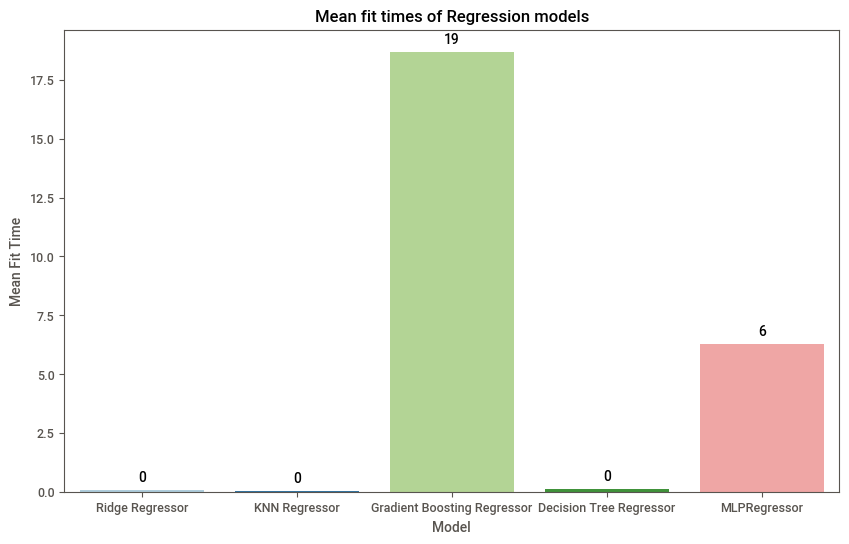

In [46]:
plt.figure(figsize = (10, 6))
splot = sns.barplot(data = final_results, x = 'Model', y = 'Mean Fit Time', hue = 'Model', legend = False, palette = 'Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.title("Mean fit times of Regression models", fontsize = 12)
plt.savefig(f'{image_dir}/machine_learning_models_fit_times.png', bbox_inches="tight")
plt.show()

Because the KNN Regressor model has the lowest mean fit time and the best Mean Absolute Error, it is selected for deployment.

In terms of revisitation, I am running all of the above for Los Angeles county as I am aware the product market in urban areas are different than for farmland and mountainous regions.

In [47]:
la = ['los angeles'] #['imperial county', 'inland empire','los angeles', 'orange county', 'palm springs', 'san diego', 'ventura county']
vehicle_df_2010_la = vehicle_df_2010_ca.query('region in @la')

In [48]:
vehicle_df_2010_la.groupby('condition')[['age','price','odometer']].mean().sort_values(by=['age'], ascending=True)

,age,price,odometer
condition,,,
new,3.500000,16160.200000,12056.400000
good,6.018466,23763.471591,47526.561080
like new,6.754545,19481.375758,62269.612121
Unknown,7.300300,15151.466967,69730.813814
salvage,7.500000,9100.000000,108760.500000
excellent,8.339599,14680.729323,87587.932331
fair,9.300000,5800.000000,125413.600000


In [49]:
title_status = vehicle_df_2010_la.groupby('title_status')[['age','price','odometer']].mean().sort_values(by=['age'], ascending=True)

In [103]:
title_status

,age,price,odometer
title_status,,,
lien,4.500000,22759.500000,34950.000000
clean,6.983004,19162.518640,64839.068531
salvage,7.184211,12570.298246,65938.315789
Unknown,7.296610,2805.796610,62530.813559
rebuilt,8.500000,35099.500000,60550.000000


<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



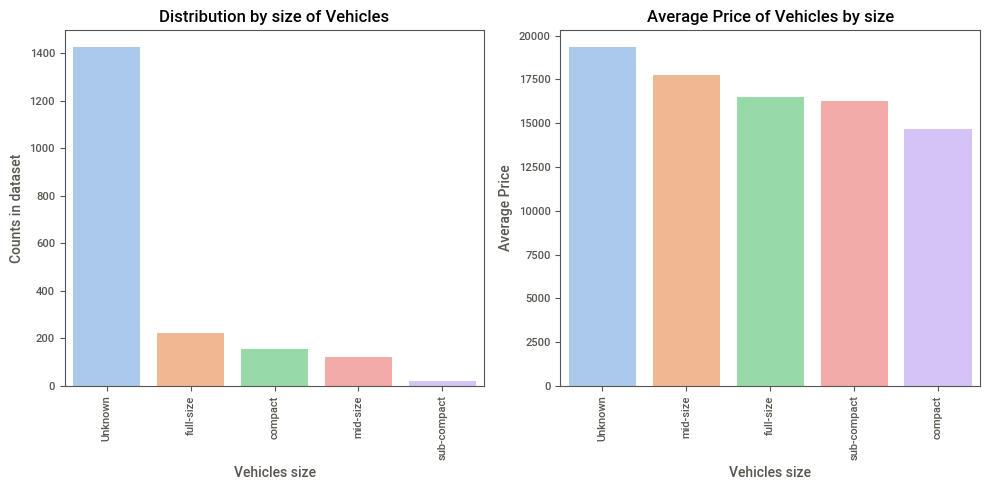

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



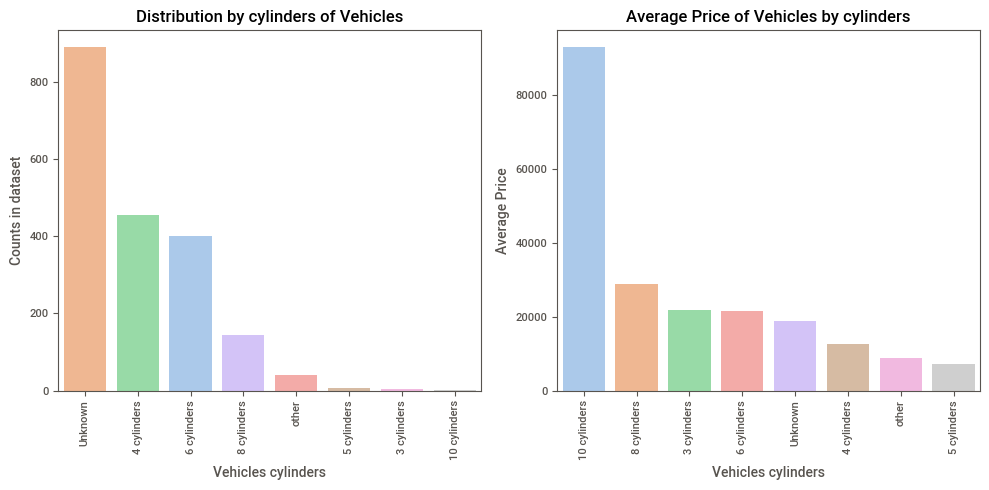

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



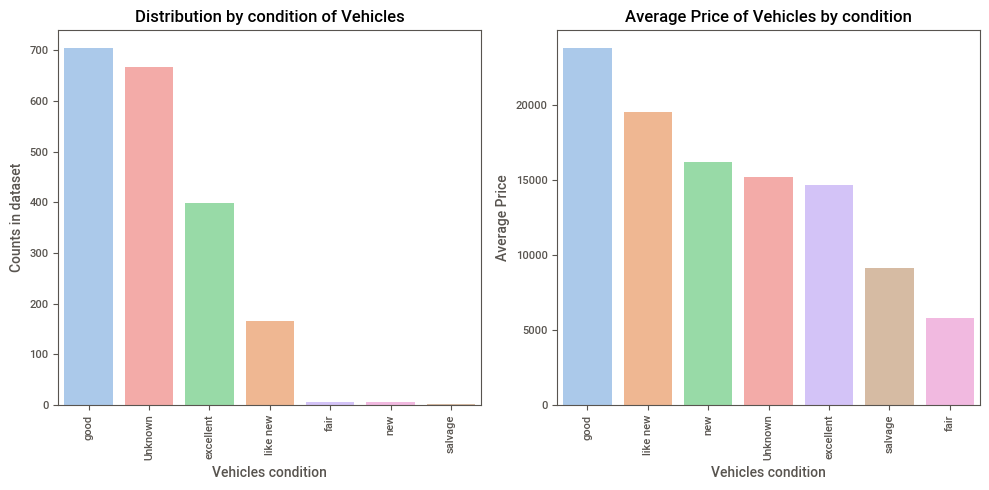

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



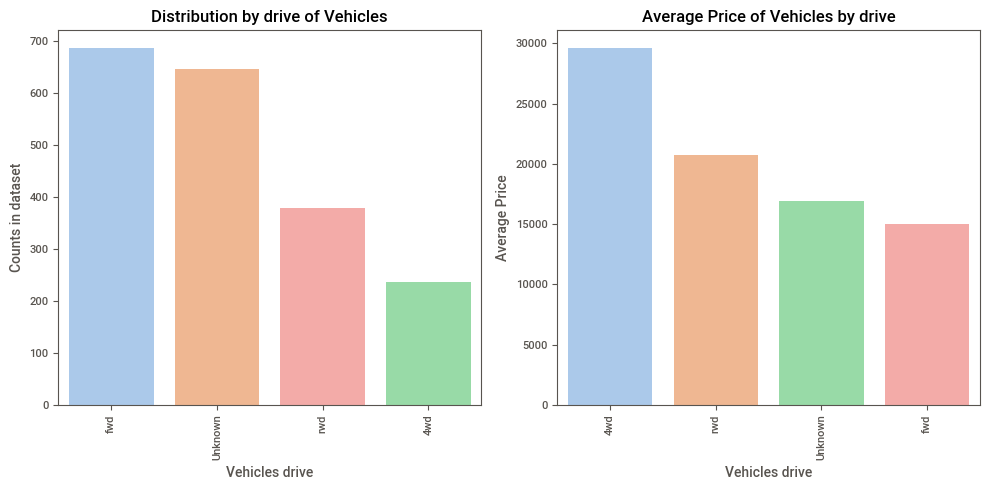

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



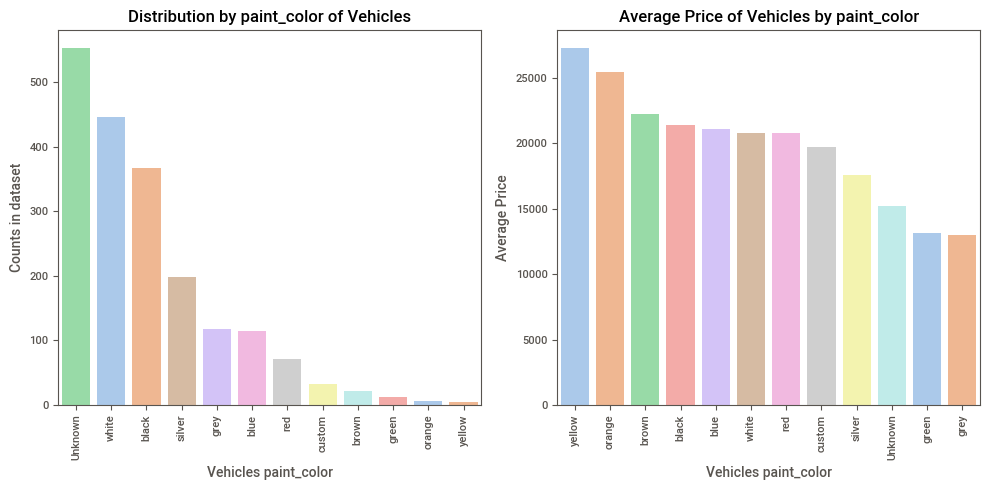

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



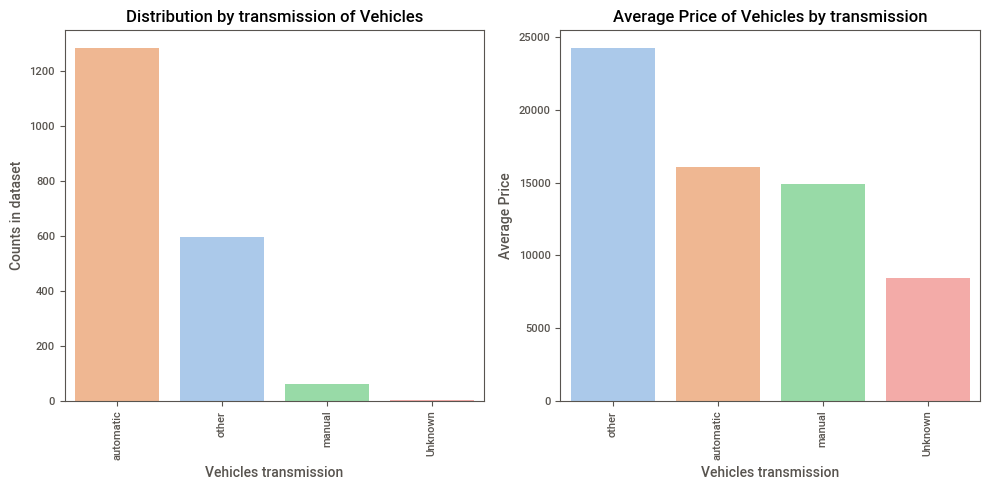

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



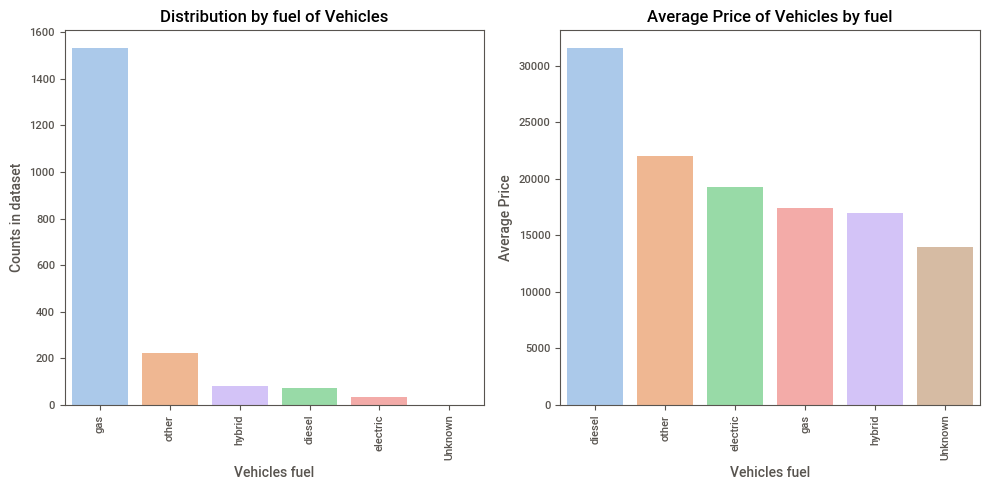

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



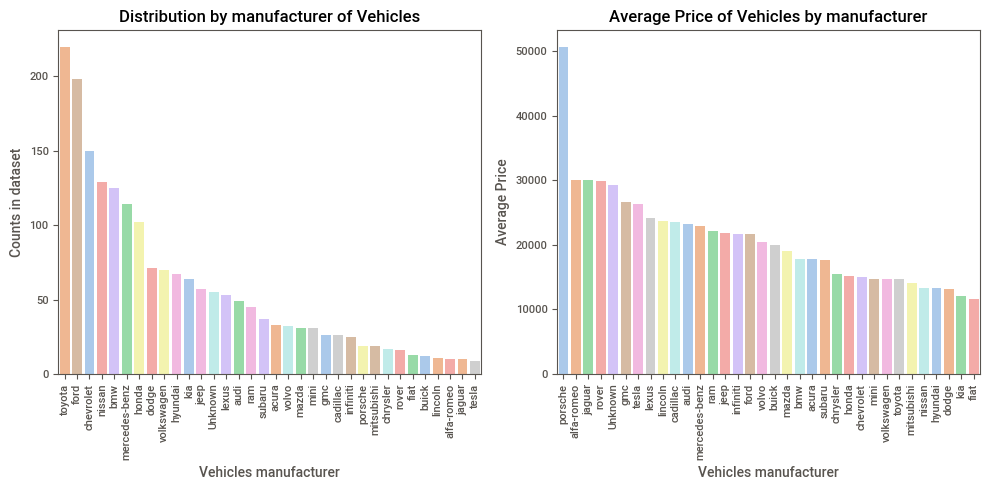

<ipython-input-20-519fb629bd63>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-20-519fb629bd63>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



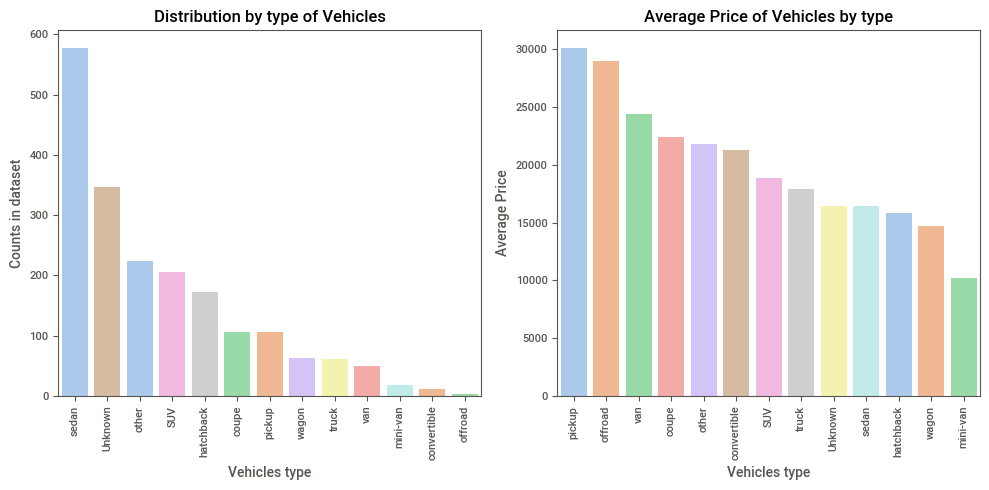

In [52]:
for column in ['size', 'cylinders', 'condition', 'drive', 'paint_color',
               'transmission', 'fuel', 'manufacturer', 'type']:
               analysis_plots(vehicle_df_2010_la,column, image_dir, 'la')

In [53]:
from sklearn import set_config
set_config(transform_output="pandas")

X = vehicle_df_2010_la.drop(['price'], axis=1)
y = vehicle_df_2010_la['price']

X_prep = pipe.fit_transform(X,y)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size = 0.3, random_state = 42)

<ipython-input-36-ec9c1cd202f3>:13: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



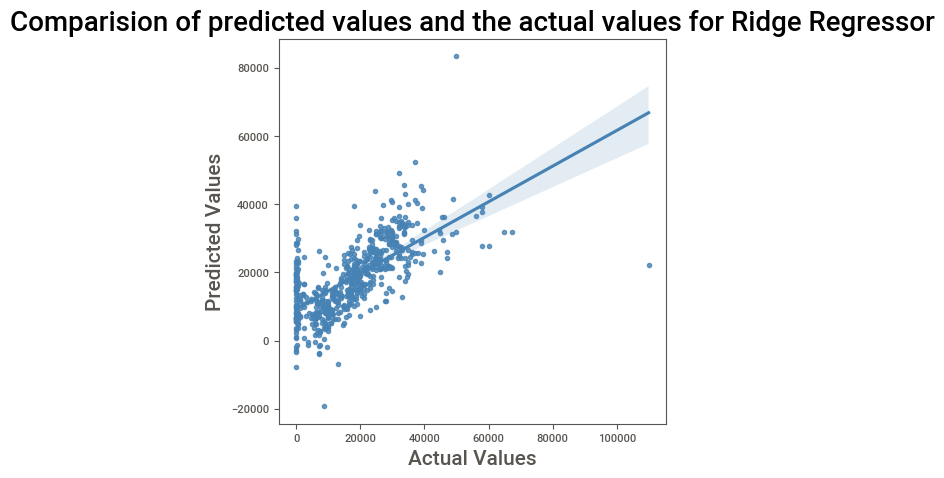

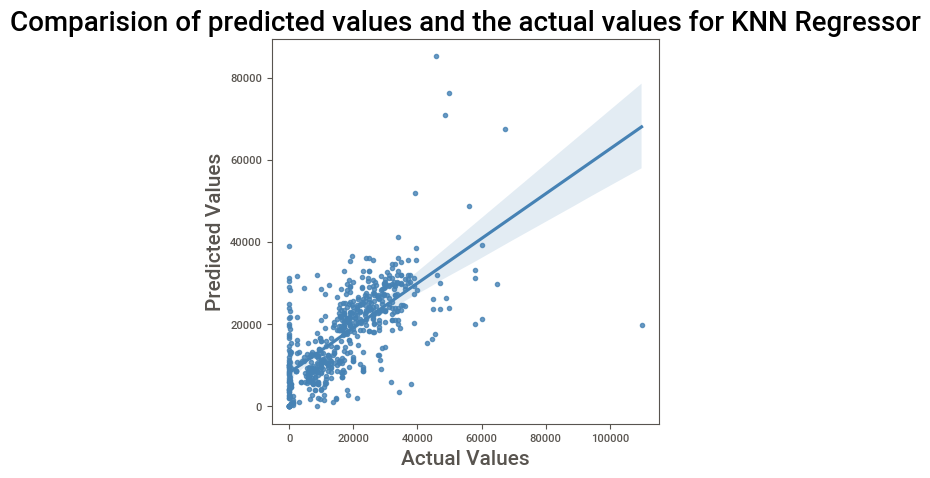

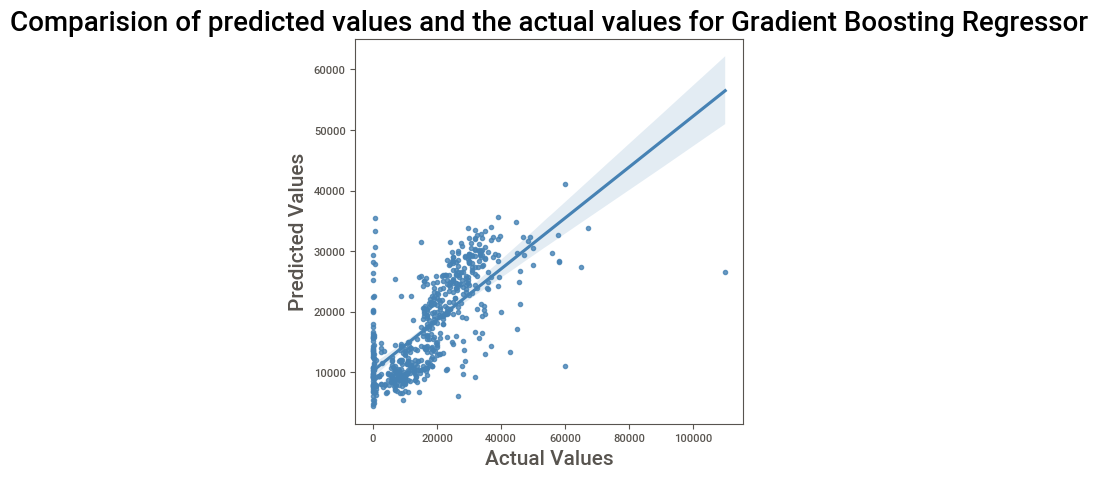

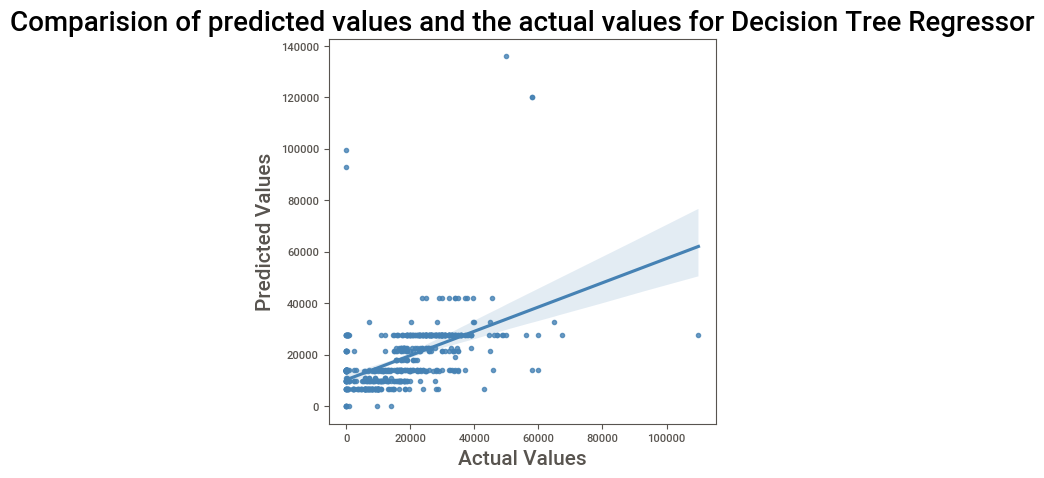

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



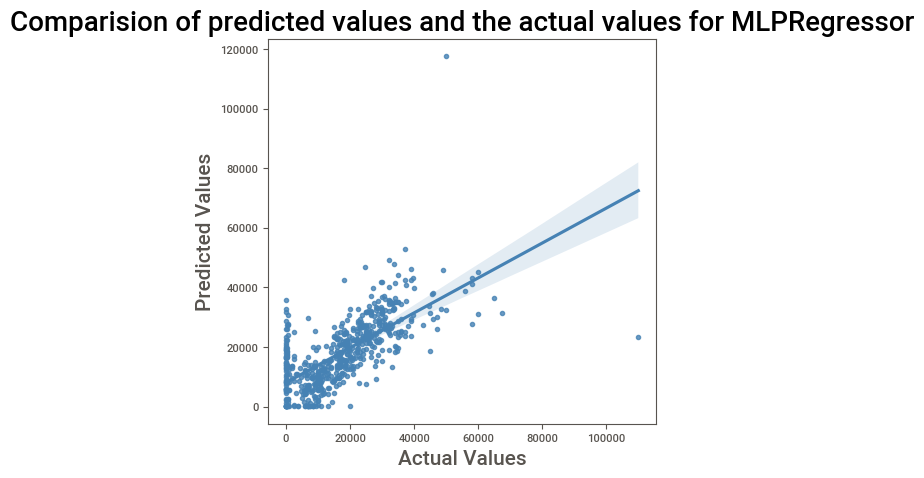

In [55]:
final_results_la = evaluate_models(model_grids, scoring = 'neg_mean_absolute_error', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, filename="socal")

In [56]:
final_results_la

,Model,Best Estimator,Train MAE,Test MAE,Best Parameters,Mean Fit Time
0,Ridge Regressor,(Ridge()),7315.666537,6962.183377,{'ridge__alpha': 1.0},0.007265
0,KNN Regressor,(KNeighborsRegressor()),5939.724523,6530.706849,{'knn__n_neighbors': 5},0.007381
0,Gradient Boosting Regressor,(([DecisionTreeRegressor(criterion='friedman_m...,6053.207769,6305.110229,"{'grad__learning_rate': 0.01, 'grad__max_depth...",2.299284
0,Decision Tree Regressor,(DecisionTreeRegressor(max_depth=5)),7580.399896,7970.145741,"{'dt__max_depth': 5, 'dt__min_samples_leaf': 1}",0.008438
0,MLPRegressor,"(MLPRegressor(alpha=0.001, hidden_layer_sizes=...",7151.618816,6840.627816,"{'mlp__hidden_layer_sizes': (1,)}",0.447760


**Comparison of Permutation importance**

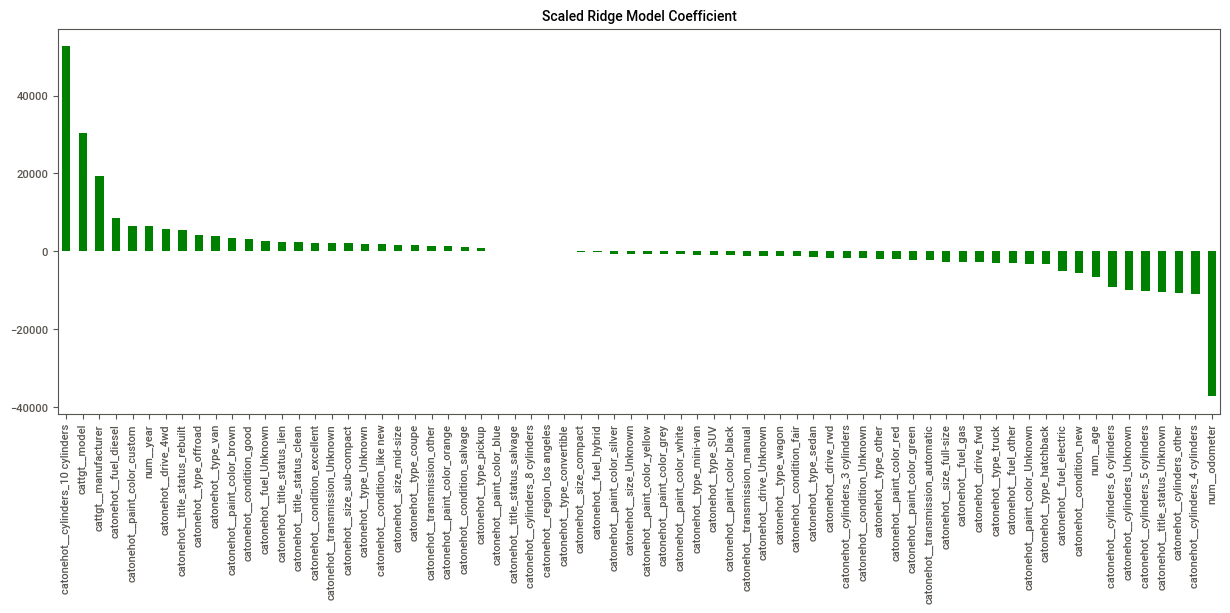

In [110]:
#For Ridge Regressor
coefficients(final_results_la.query('Model == "Ridge Regressor"')['Best Estimator'].values[0])

For KNN Regressor - Permutation importance

In [ ]:
from sklearn.inspection import permutation_importance


# Example of using Permutation Importance:
model = final_results_la.query('Model == "KNN Regressor"')['Best Estimator'].values[0]
model_fit = model.fit(X_train, y_train)
perm = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)



In [122]:
for i in perm.importances_mean.argsort()[::-1]:
    if perm.importances_mean[i] - 2 * perm.importances_std[i] > 0:
        print(f"{feature_names[i]:<8}"
              f"{perm.importances_mean[i]:.3f}"
              f" +/- {perm.importances_std[i]:.3f}")

catonehot__paint_color_Unknown0.048 +/- 0.020
catonehot__drive_rwd0.035 +/- 0.012
catonehot__condition_good0.034 +/- 0.013
catonehot__drive_fwd0.031 +/- 0.015
catonehot__type_coupe0.015 +/- 0.006
catonehot__size_compact0.008 +/- 0.003
catonehot__type_mini-van0.006 +/- 0.001
catonehot__type_hatchback0.005 +/- 0.002
catonehot__type_truck0.005 +/- 0.002
catonehot__fuel_electric0.003 +/- 0.001
catonehot__transmission_Unknown0.001 +/- 0.000
catonehot__cylinders_5 cylinders0.000 +/- 0.000


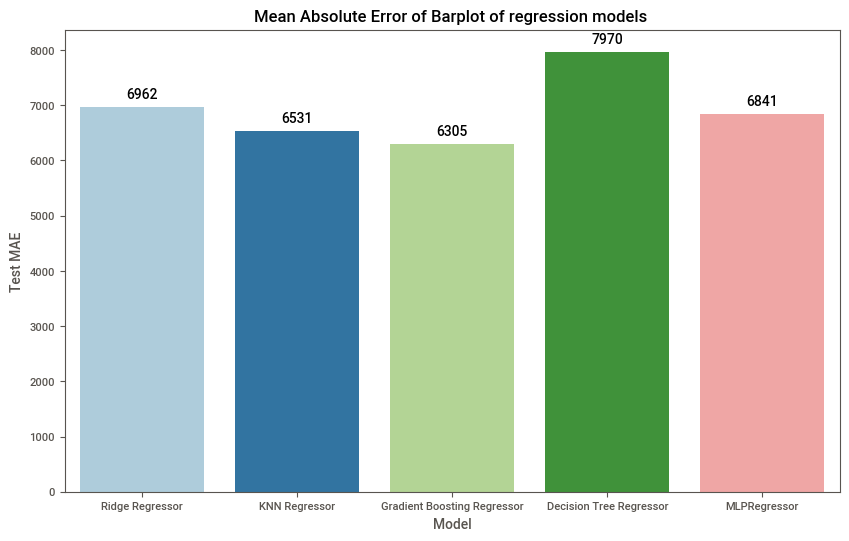

In [57]:
plt.figure(figsize = (10, 6))
splot = sns.barplot(data = final_results_la, x = 'Model', y = 'Test MAE', hue = 'Model', legend = False, palette = 'Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title("Mean Absolute Error of Barplot of regression models ", fontsize = 12)
plt.savefig(f'{image_dir}/machine_learning_models_outcomes_socal.png',bbox_inches="tight")
plt.show()

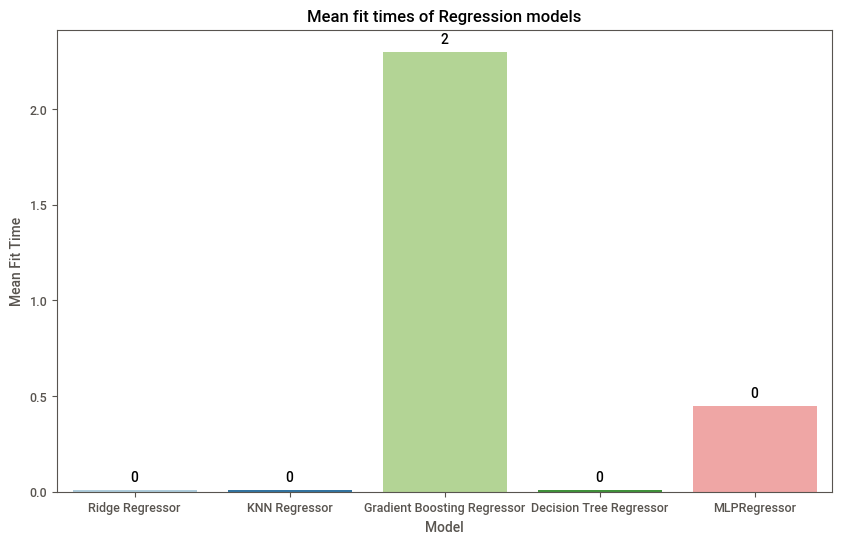

In [58]:
plt.figure(figsize = (10, 6))
splot = sns.barplot(data = final_results_la, x = 'Model', y = 'Mean Fit Time', hue = 'Model', legend = False, palette = 'Paired')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.title("Mean fit times of Regression models", fontsize = 12)
plt.savefig(f'{image_dir}/machine_learning_models_fit_times_la.png', bbox_inches="tight")
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

The dataset includes outliers, so I have opted to use the Mean Absolute Error instead of Mean Squared Error as it is less sensitive to outliers.  

In [81]:
vehicle_df_2010_la['age_interval'] = pd.cut(vehicle_df_2010_la['age'], bins=[0, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')],
                                               labels=['0-3','3-4','4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10+'])

<ipython-input-81-673c8584d26f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
age_price = vehicle_df_2010_la.groupby('age_interval')[['price']].mean().sort_values(by=['age_interval'], ascending=True)

<ipython-input-80-10ef365af8ea>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



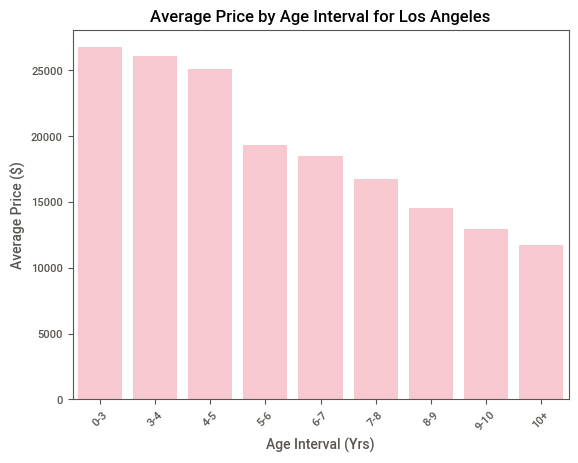

In [77]:
sns.barplot(data=age_price, x='age_interval', y='price',color='pink')
plt.xticks(rotation=45)
plt.title('Average Price by Age Interval for Los Angeles')
plt.xlabel('Age Interval (Yrs)')
plt.ylabel('Average Price ($)')
plt.savefig(f'{image_dir}/average_price_by_age_interval_la.png', bbox_inches="tight")
plt.show()

In [98]:
age_type = vehicle_df_2010_la.groupby(['age_interval', 'type'])[['price']].mean('price').sort_values(by=['age_interval'], ascending=True)

<ipython-input-98-eec303183778>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [99]:
age_type.query('age_interval == "0-3"').sort_values(by=['price'], ascending=False)

price
age_interval type                     
0-3          truck        58998.333333
             pickup       36571.500000
             wagon        35990.000000
             coupe        35542.500000
             SUV          34326.500000
             van          30526.666667
             other        27430.736842
             Unknown      23121.157895
             hatchback    22955.714286
             sedan        21966.000000
             mini-van              NaN
             convertible           NaN
             offroad               NaN

In [102]:
age_type.query('(age_interval == "9-10") or (age_interval == "10+")').sort_values(by=['price'], ascending=False)

price
age_interval type                     
10+          pickup       27723.916667
9-10         truck        25533.500000
             pickup       22677.727273
             coupe        19676.666667
10+          convertible  19164.333333
9-10         wagon        16167.250000
             other        13555.000000
10+          Unknown      12995.077670
             truck        12880.933333
             coupe        12876.875000
9-10         SUV          12506.800000
             van          12242.500000
10+          other        12145.434783
             van          11898.333333
9-10         Unknown      11748.738095
10+          SUV          10682.551020
9-10         sedan        10640.000000
10+          sedan        10238.295455
9-10         hatchback     9559.818182
10+          mini-van      9183.571429
             wagon         7209.470588
             offroad       7000.000000
9-10         convertible   6995.000000
10+          hatchback     6179.260870
9-10         mini-van      5200.000000
             offroad               NaN

**Findings**


1. Competitive Pricing: Pricing is one of the biggest determinants in the sale of used cars. Cars depreciate at different rates, and understanding this helps adjust the car prices accordingly.


2. Vehicle Condition
Mileage: Cars with lower mileage tend to sell faster because they are perceived as having more life left. A vehicle in good condition will attract more buyers.

3. Vehicle Age and Model
Age: Newer used cars tend to sell faster as they often have updated features and lower wear and tear. However, older models that are well-maintained can still attract buyers.
Make and Model Reputation: Some makes and models retain their value better than others due to their reliability, reputation, and popularity. Brands known for longevity like Toyota and Honda may sell faster.


4. Market Demand
Popular Models: Certain types of vehicles, such as SUVs and trucks, may have higher demand in specific markets. Local preferences can significantly impact how quickly a car sells.
- Toyota, Ford, sell at the highest volume in Los Angeles.
- Chevrolet, Nissan, BMW, Mercedes-Benz and Honda follow in at a lower volume tier
Seasonal Trends: The time of year can affect demand. However we do not have granularity beyond a year.

5. Accident History: Vehicles with a clean accident history are more likely to sell at a higher price.

6. Fuel Efficiency
Gas cars sell in higher volume in Los Angeles. However that trend is likely to change in california in the coming years due to emission standards. Electric cars with low emissions may be in higher demand. Diesel vehicles are priced higher as can be seen in the above analysis for trucks and pickups.

7. Location
Certain vehicles sell better in specific regions based on climate and lifestyle preferences. Front Wheel Drives sell the most in Los Angeles,  and SUVs might sell better in rural or mountainous areas, while smaller, fuel-efficient cars are more popular in urban environments.

8. Paint Color
White, Black, and Silver colored cars sell at the highest volume. Custom colors such as yellow, orange, brown are priced higher but sell at a lower volume.

9. Transmission type
Automatic cars are the most popular in this city.

10. Size
Full-size cars sell the most

11. Cylinders
4-cylinders are popular, closely followed by 6-cylinders. 10-cylinder trucks are priced higher. The niche markets for trucks could be by the port of Los Angeles

The dataset includes outliers, so I have opted to use the Mean Absolute Error instead of Mean Squared Error as it is less sensitive to outliers.
The best model is the KNN Regressor.

Next Steps and recommendations



*   Gather more data on Ferrarri and Aston Martin
*   Gather newer data on electric vehicle. Their used car data is mostly missing.
* Deploy the model

